<a href="https://colab.research.google.com/github/manjhidarsh/Sepsis/blob/main/Sepsis_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d salikhussaini49/prediction-of-sepsis

Dataset URL: https://www.kaggle.com/datasets/salikhussaini49/prediction-of-sepsis
License(s): CC-BY-NC-SA-4.0
100% 74.7M/74.7M [00:04<00:00, 26.8MB/s]
100% 74.7M/74.7M [00:04<00:00, 18.2MB/s]


In [6]:
from zipfile import ZipFile
dataset = '/content/prediction-of-sepsis.zip'

with ZipFile(dataset, 'r') as zip:
  zip.extractall()
  print("dataset extracted")

dataset extracted


In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import RocCurveDisplay
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [8]:
combined = pd.read_csv('/content/Dataset.csv')

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) == 6)]
df_train = combined.drop(rows_to_drop.index)
df_train.to_csv('data_part1.csv', index=False)

rows_to_drop = combined.loc[combined['Patient_ID'].apply(lambda x: len(str(x)) != 6)]
df_test = combined.drop(rows_to_drop.index)
df_test.to_csv('data_part2.csv', index=False)

In [9]:
df_train = pd.read_csv('/content/data_part1.csv')
df_test = pd.read_csv('/content/data_part2.csv')

In [10]:
patients = list(df_test['Patient_ID'].unique())
len(patients)

20000

In [11]:
def corr_matrix(df):
  corr = df.corr()
  mask = np.triu(np.ones_like(corr, dtype=bool))
  f, ax = plt.subplots(figsize=(40,40))
  cmap = sns.diverging_palette(220, 10, as_cmap=True)
  sns.heatmap(corr, mask=mask, cmap="Paired", vmax=.3, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [12]:
null_values = df_train.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
EtCO2,100.000000
TroponinI,99.877881
Bilirubin_direct,99.850420
Fibrinogen,99.236917
Bilirubin_total,98.773372
Alkalinephos,98.540650
AST,98.504205
Lactate,96.565112
PTT,95.152459
SaO2,95.044387


In [13]:
columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
df_train = df_train.assign(Unit=df_train['Unit1'] + df_train['Unit2'])
df_train_mod = df_train.drop(columns=columns_drop)
df_train_mod.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'FiO2', 'SaO2', 'AST',
       'BUN', 'Chloride', 'Creatinine', 'Bilirubin_direct', 'Glucose',
       'Lactate', 'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'WBC',
       'Platelets', 'Age', 'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel',
       'Patient_ID', 'Unit'],
      dtype='object')

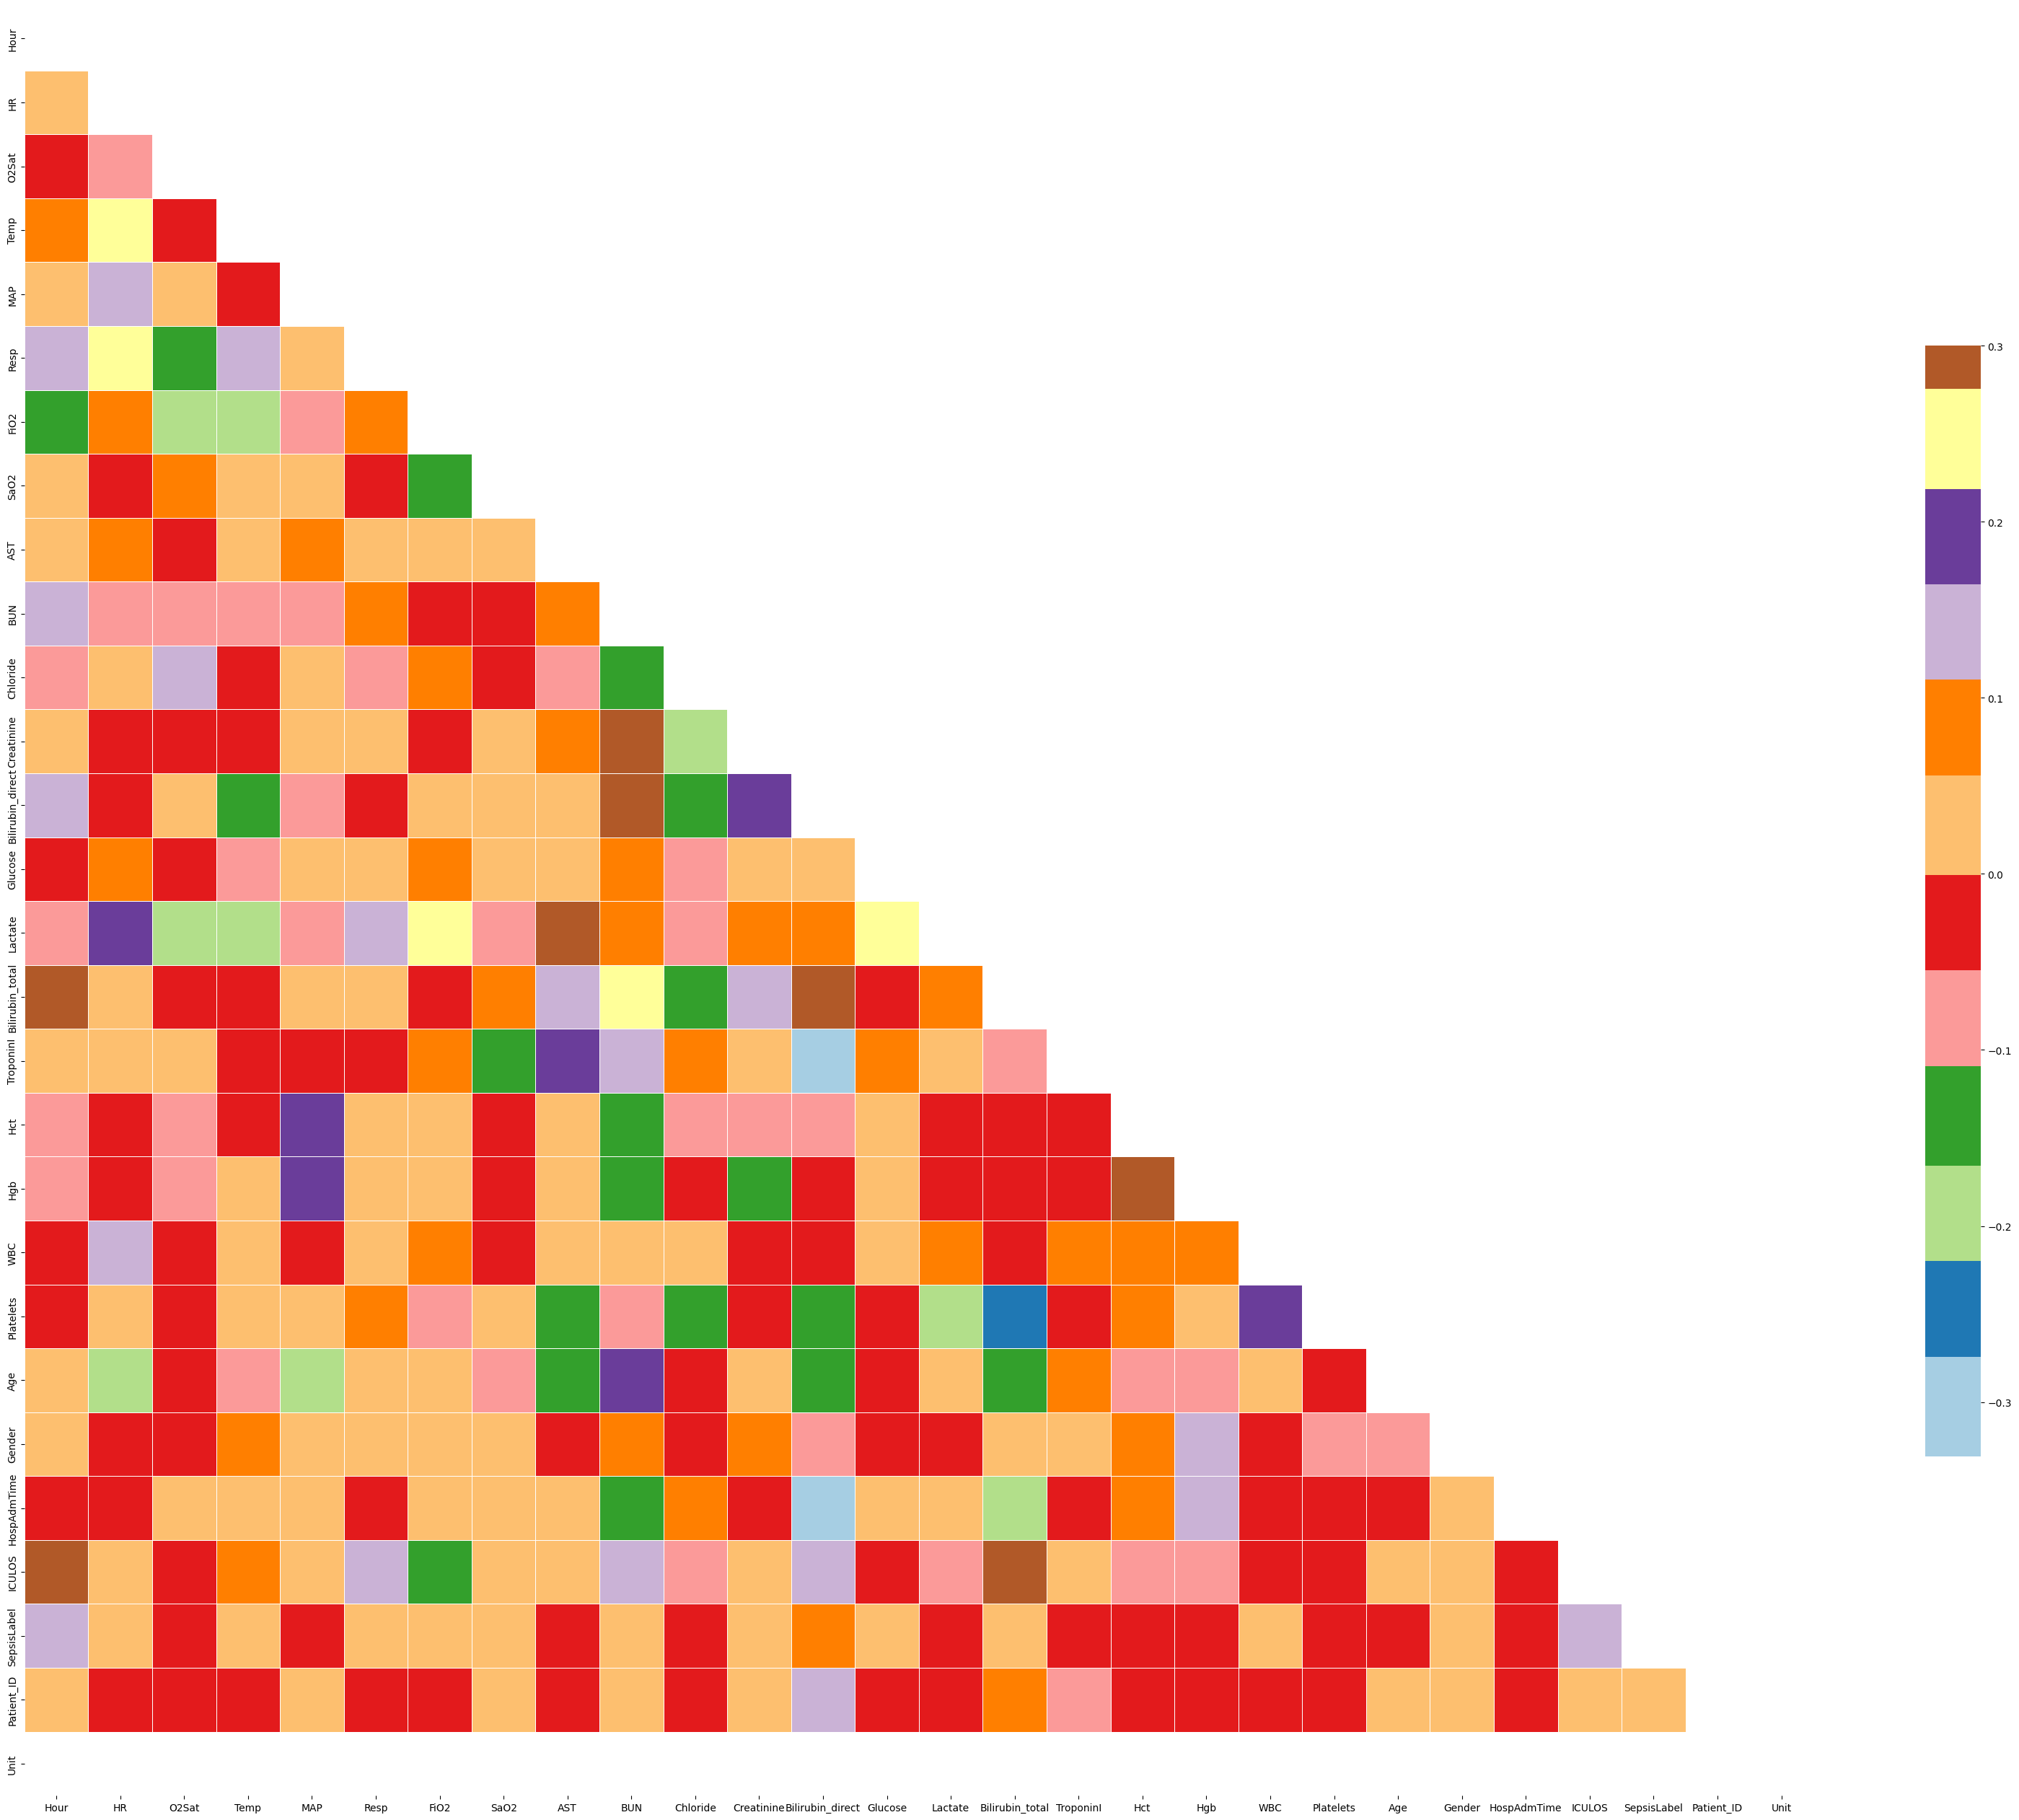

In [14]:
corr_matrix(df_train_mod)

In [15]:
df_train_impute = df_train_mod.copy()
columns_impute = list(df_train_impute.columns)

In [16]:
# bfill and ffill for imputing

grouped_by_patient = df_train_impute.groupby('Patient_ID')
df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())

<ipython-input-16-630336680b91>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [17]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp  FiO2  SaO2   AST  \
Patient_ID                                                                    
1          132940     0   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  0.28  88.0  16.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  0.28  88.0  16.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  0.28  88.0  16.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  0.28  88.0  16.0   

                    BUN  ...   Hgb  WBC  Platelets    Age  Gender  \
Patient_ID               ...                                        
1          132940  14.0  ...  12.5  5.7      317.0  83.14       0   
           132941  14.0  ...  12.5  5.7      317.0  83.14       0   
           132942  14.0  ...  12.5  5.7      317.0  83.14       0   
           132943  14.0  ...  12.5  5.7      317.0  83.14       0   
           132944  14.0  ...  12.5  5.7      317.0  83.14       0   

                   HospAdmTime  ICULOS  SepsisLabel  Patient_ID  Unit  
Patient_ID                                                             
1          132940        -0.03       1            0           1   NaN  
           132941        -0.03       2            0           1   NaN  
           132942        -0.03       3            0           1   NaN  
           132943        -0.03       4            0           1   NaN  
           132944        -0.03       5            0           1   NaN  

[5 rows x 28 columns]

In [18]:
null_values = df_train_impute.isnull().mean()*100
null_values = null_values.sort_values(ascending=False)
null_values

,0
TroponinI,97.357934
Bilirubin_direct,96.256841
Bilirubin_total,66.949754
AST,66.435590
SaO2,57.282891
Lactate,55.997418
Unit,48.868346
FiO2,36.195592
WBC,1.511994
Platelets,1.394810


In [19]:
null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
            'Unit', 'Patient_ID']
df_train_impute = df_train_impute.drop(columns=null_col)
df_train_impute.columns

Index(['Hour', 'HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets', 'Age',
       'Gender', 'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [20]:
# onehot encoding the gender

one_hot = pd.get_dummies(df_train_impute['Gender'])
df_train_impute = df_train_impute.join(one_hot)
df_train_impute = df_train_impute.drop('Gender', axis=1)

In [21]:
def diagnostic_plots(df, variable):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(121)
    df[variable].hist(bins=30)
    ax = fig.add_subplot(122)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.xlabel(variable)
    plt.show()

In [22]:
# function to apply different transformations to make the plot gaussian

def try_gaussian(df, col):
  df[col] = df[col].fillna(df[col].mean())  # Replace NaN with the mean of the column
  df[col] = df[col].replace([np.inf, -np.inf], df[col].mean())  # Replace inf with the mean of the column
  print('actual plot')
  diagnostic_plots(df,col)
  # this applies yeojohnson plot
  df['col_yj'], param = stats.yeojohnson(df[col])
  print('yeojohnson plot')
  diagnostic_plots(df, 'col_yj')
  # this applies exponential transformation
  df['col_1.5'] = df[col]**(1/1.5)
  print('**1/1.5 plot')
  diagnostic_plots(df, 'col_1.5')
  df['col_.5'] = df[col]**(.5)
  print('**.5 plot')
  # this applies inverse transformation
  diagnostic_plots(df, 'col_.5')
  df['col_rec'] = 1 / (df[col]+0.00001)
  diagnostic_plots(df, 'col_rec')
  # this applies logarithmic trasnformation
  df['col_log'] = np.log(df[col]+1)
  diagnostic_plots(df, 'col_log')

O2Sat
actual plot


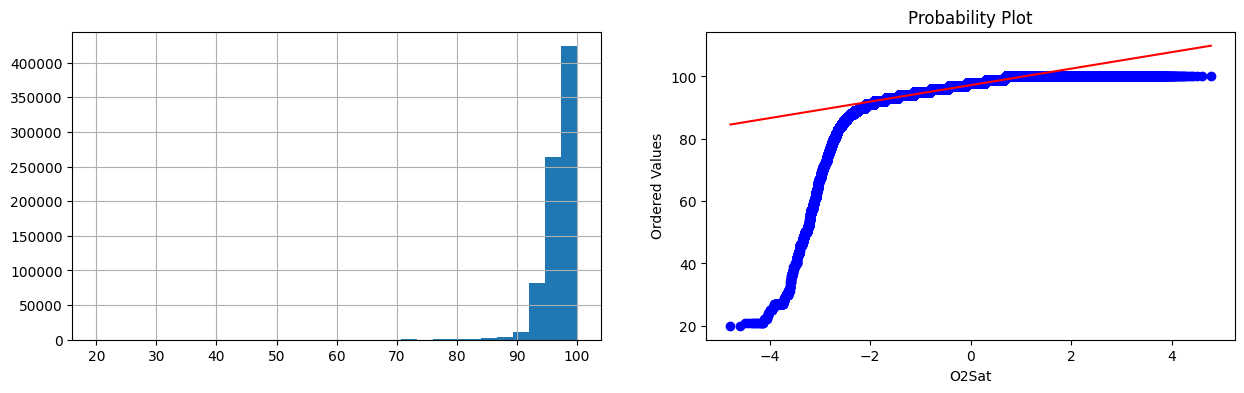

yeojohnson plot


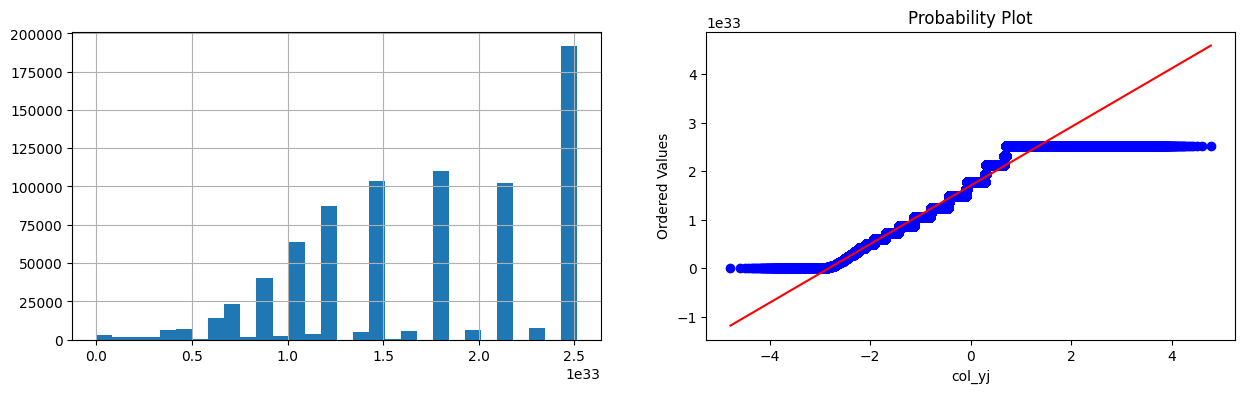

**1/1.5 plot


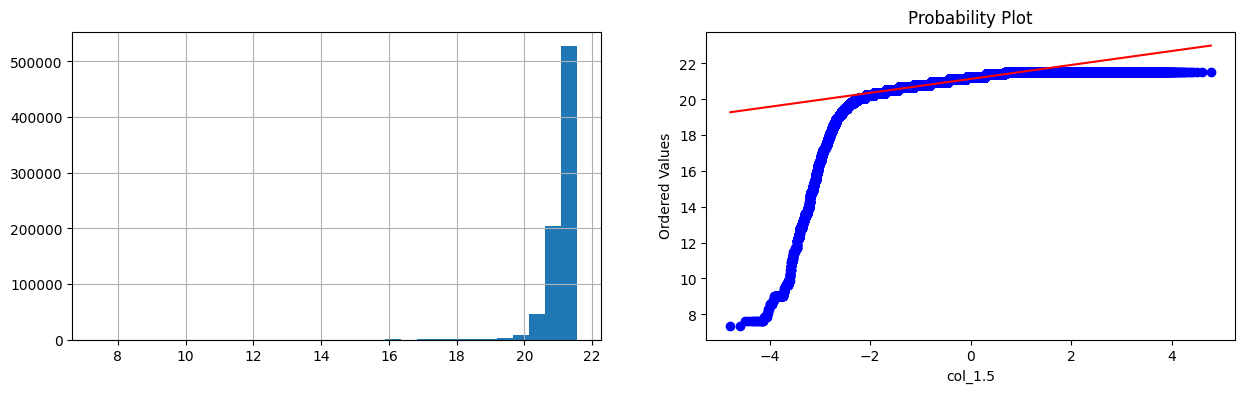

**.5 plot


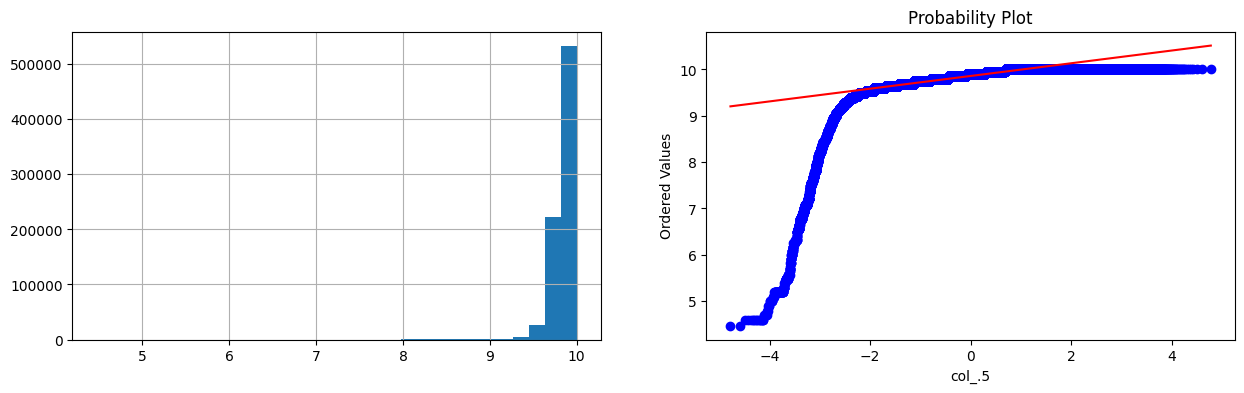

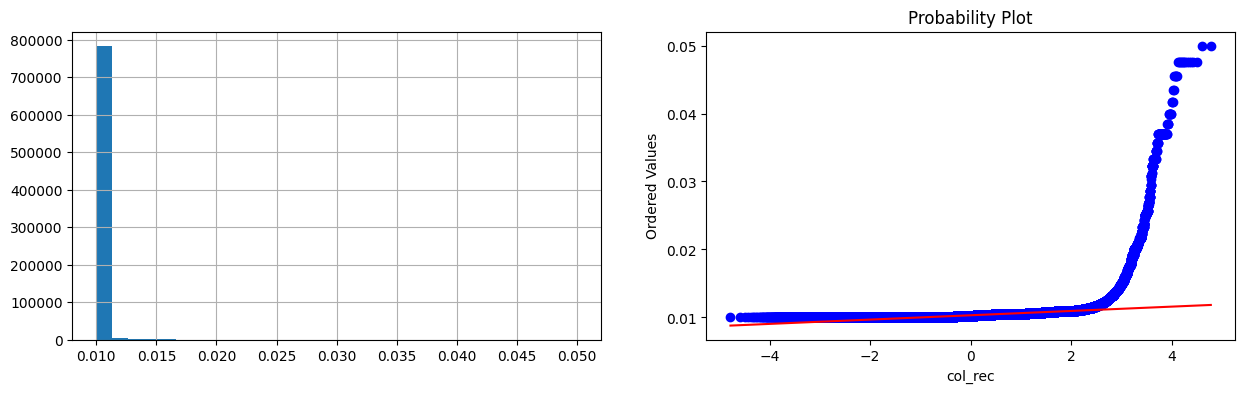

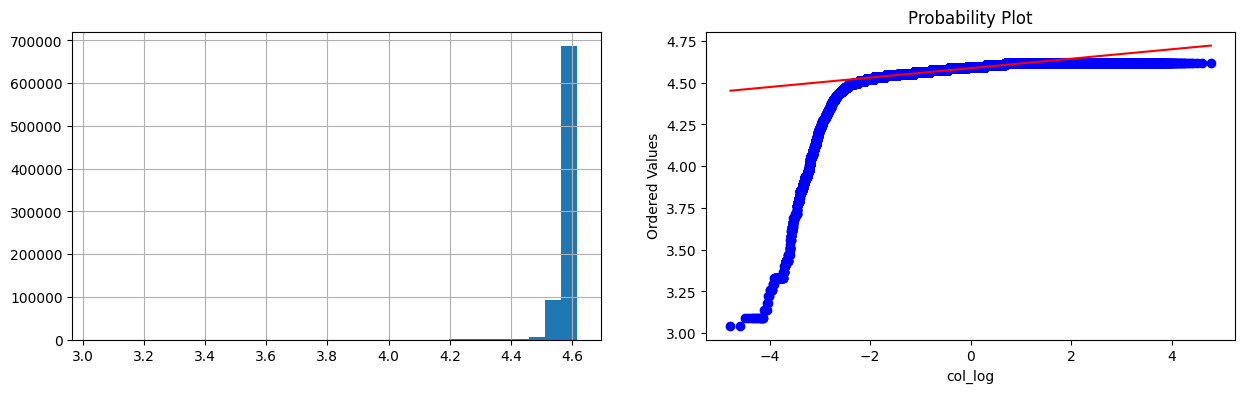

Temp
actual plot


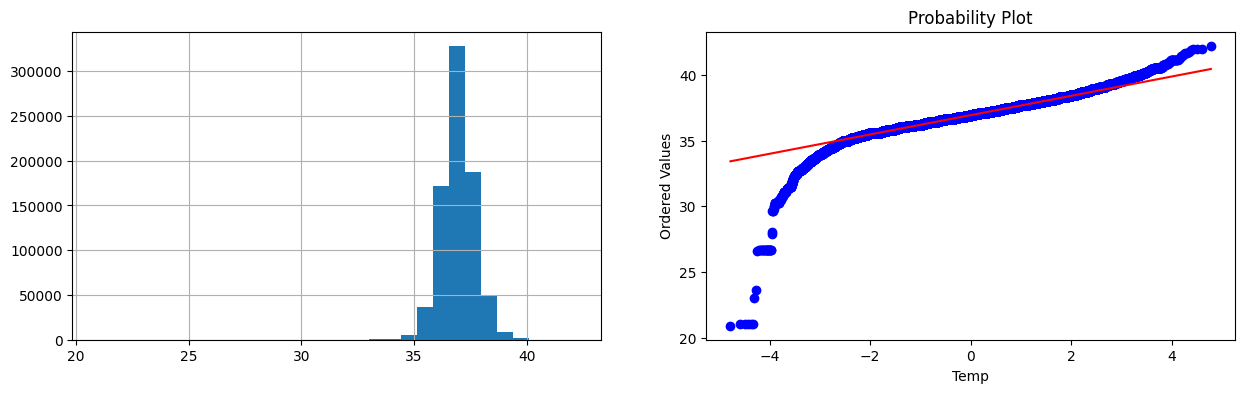

yeojohnson plot


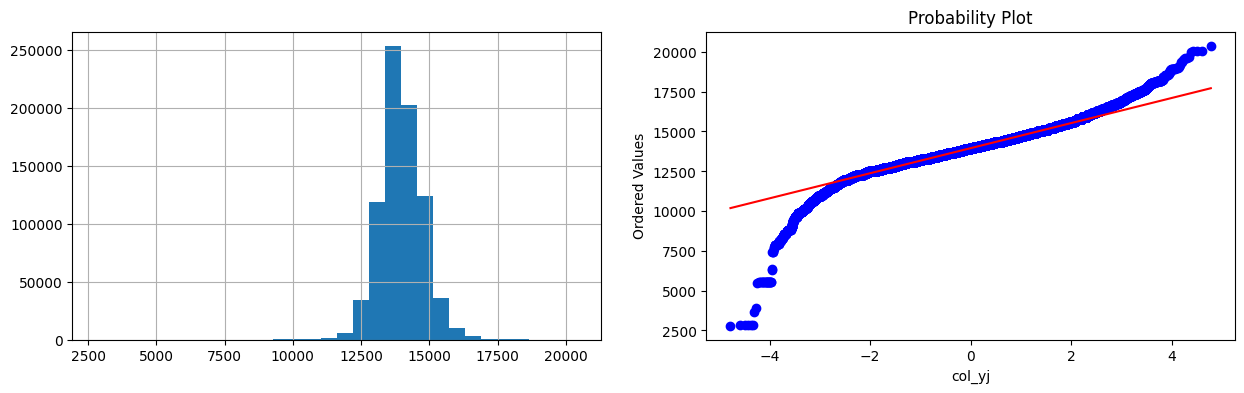

**1/1.5 plot


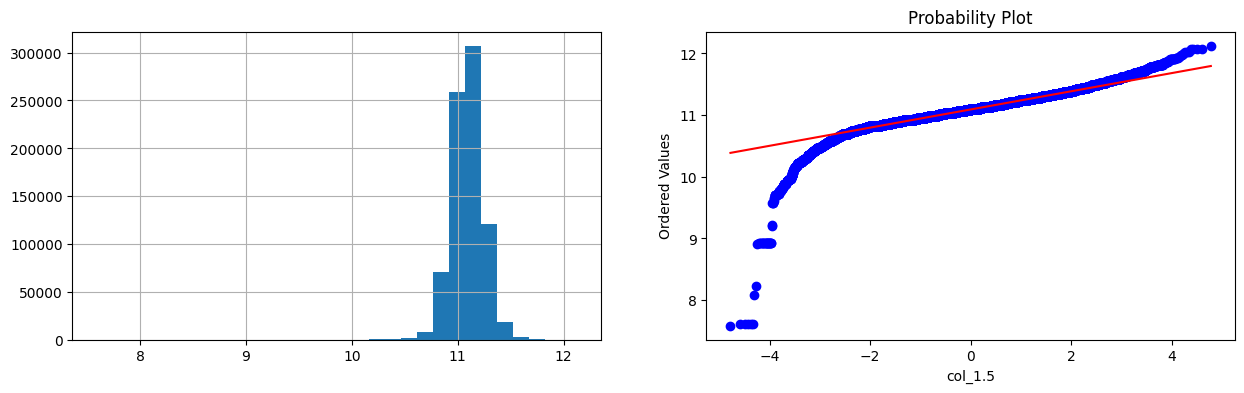

**.5 plot


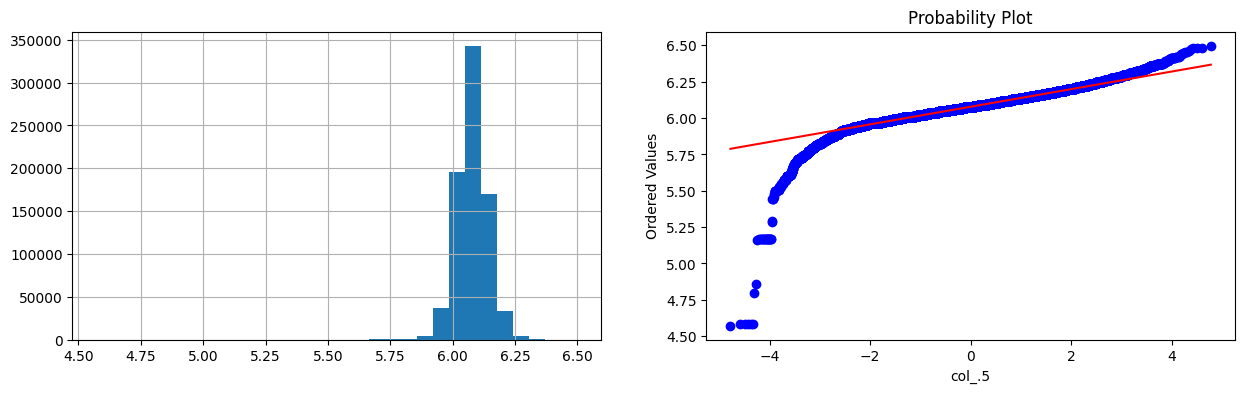

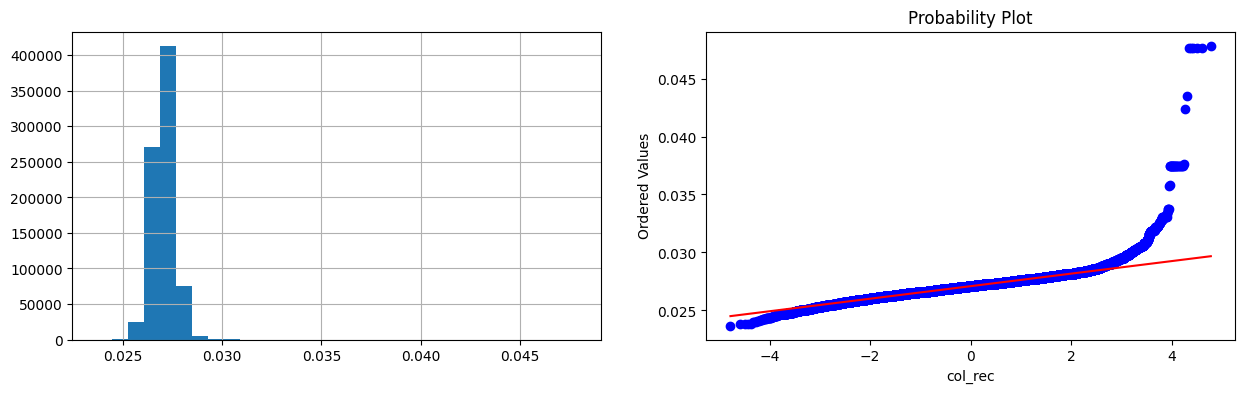

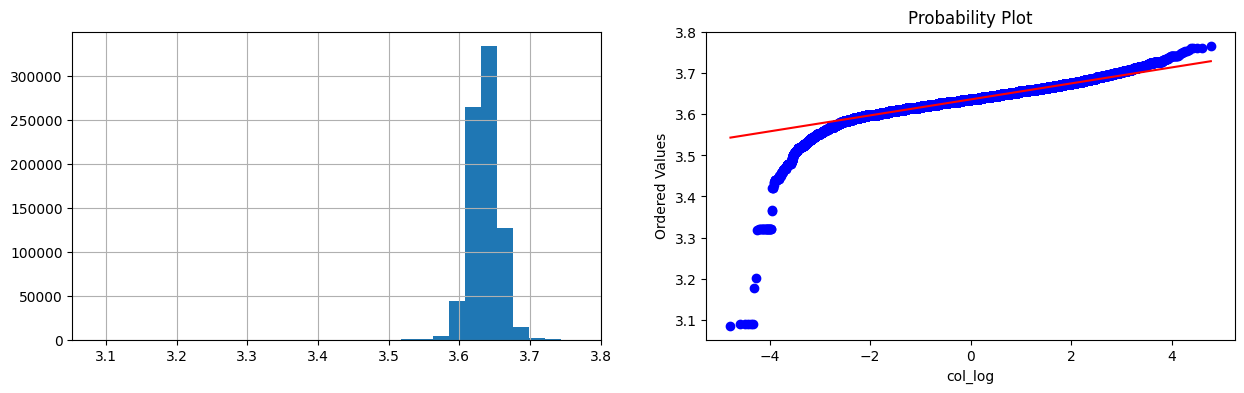

MAP
actual plot


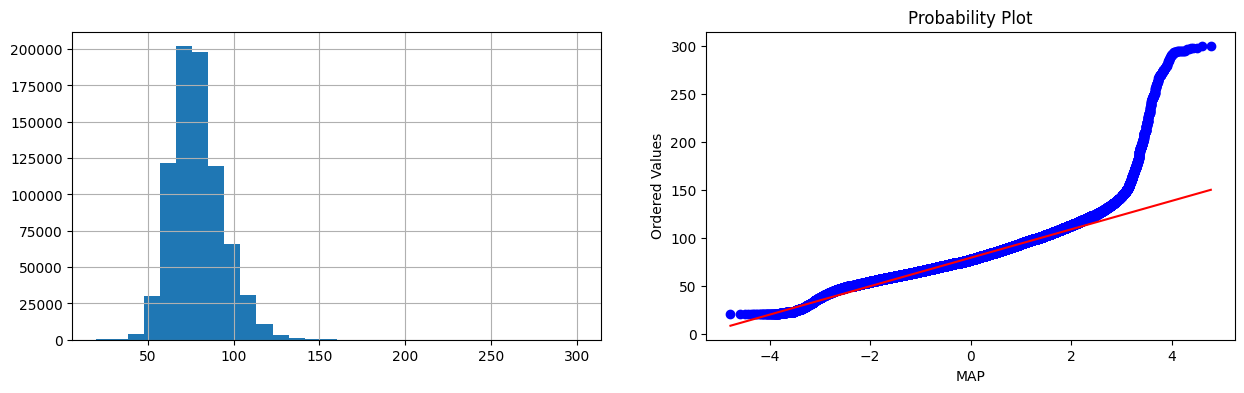

yeojohnson plot


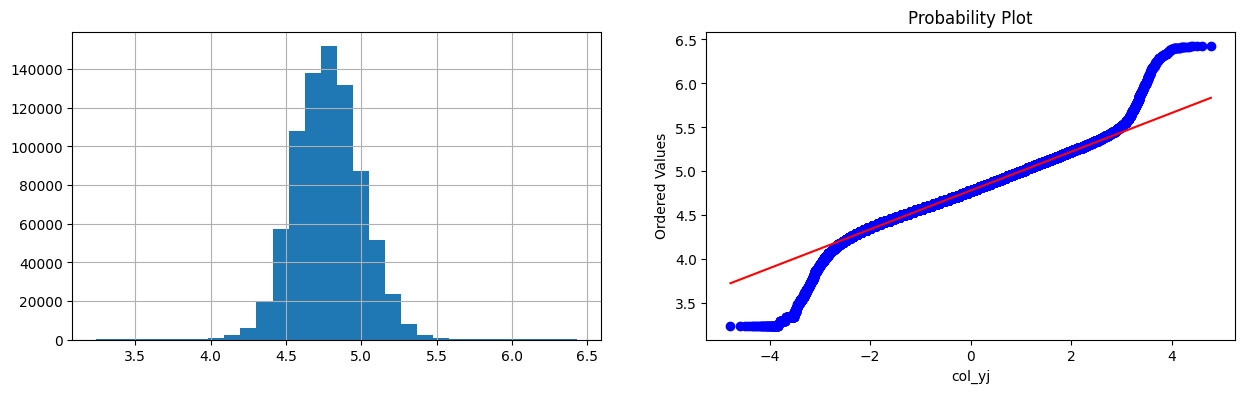

**1/1.5 plot


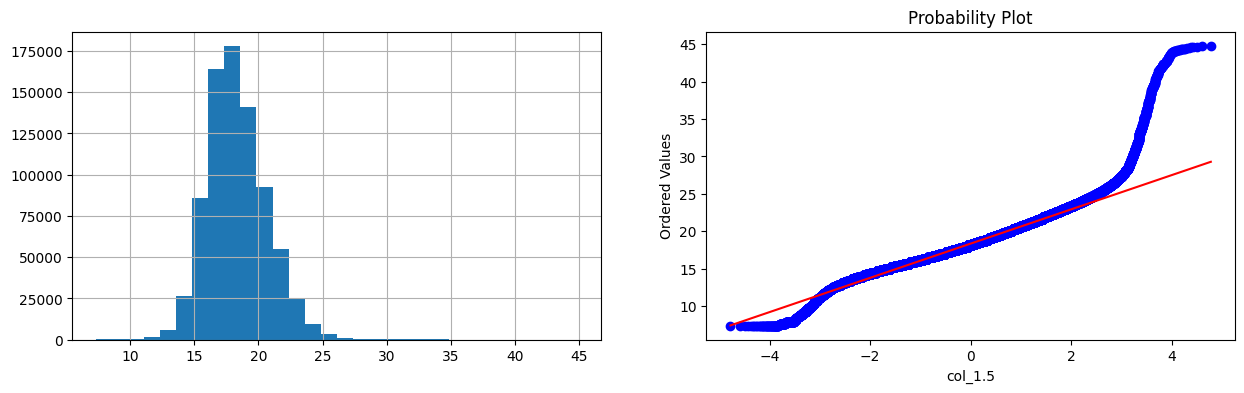

**.5 plot


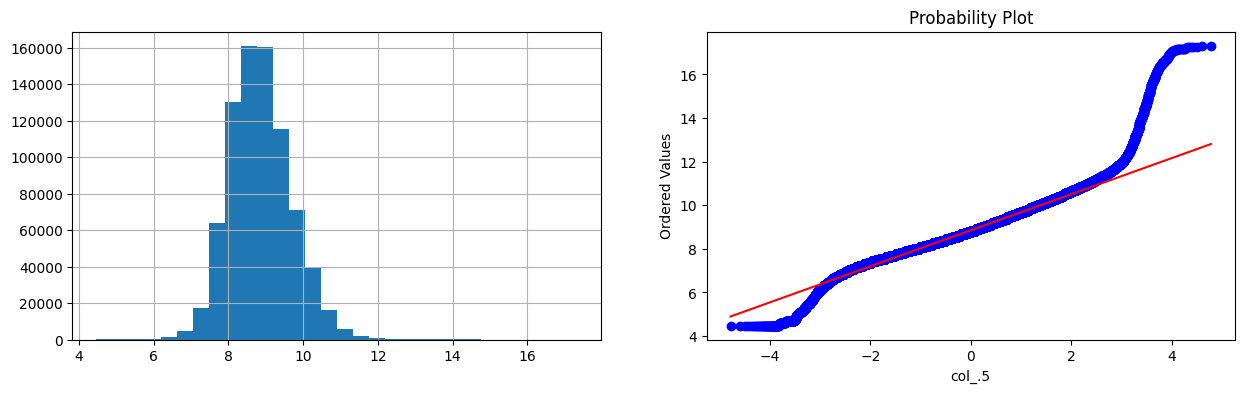

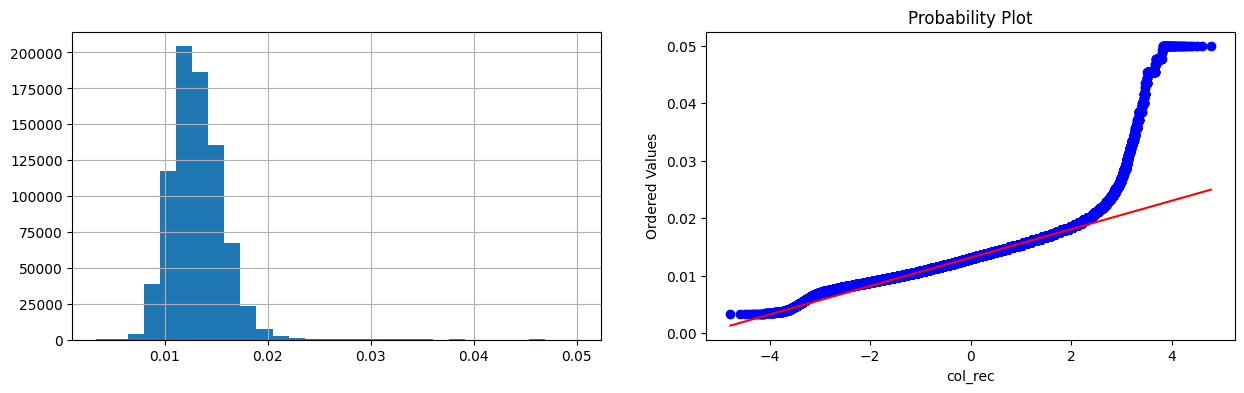

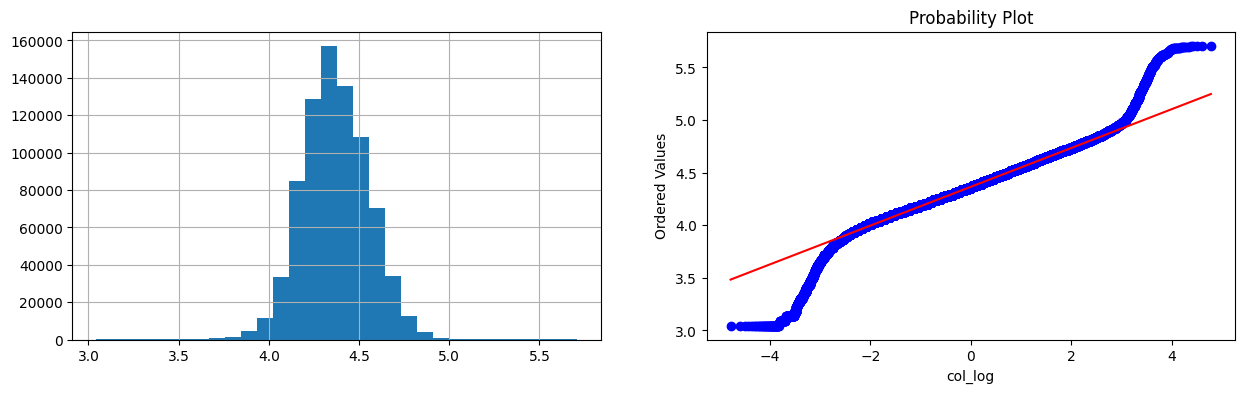

BUN
actual plot


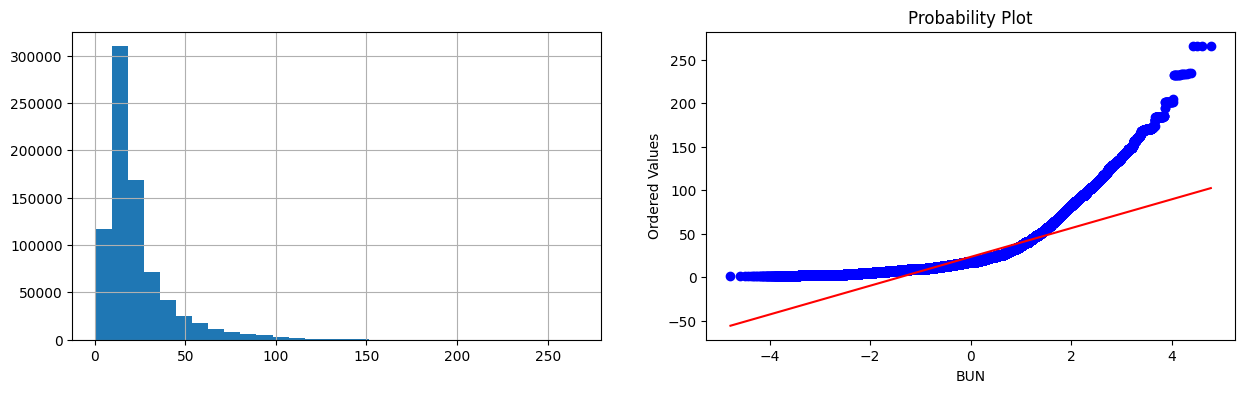

yeojohnson plot


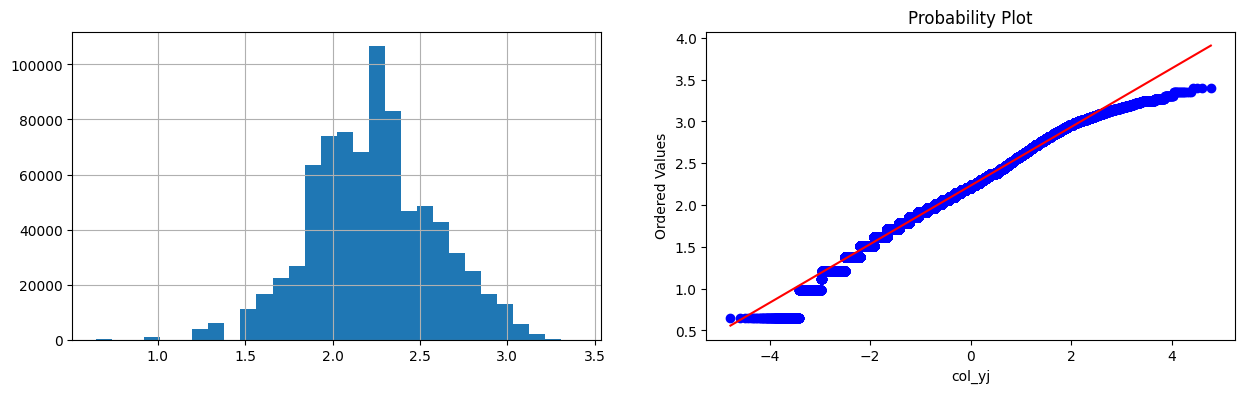

**1/1.5 plot


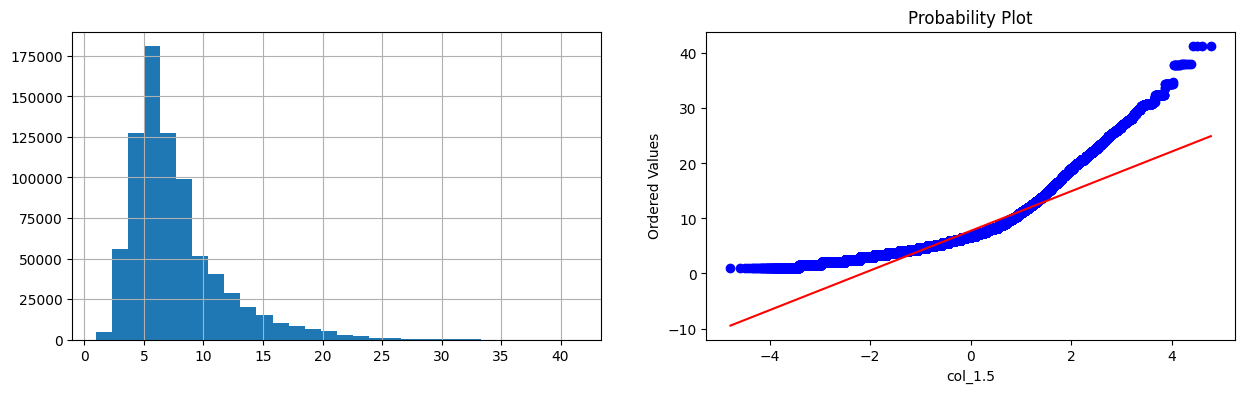

**.5 plot


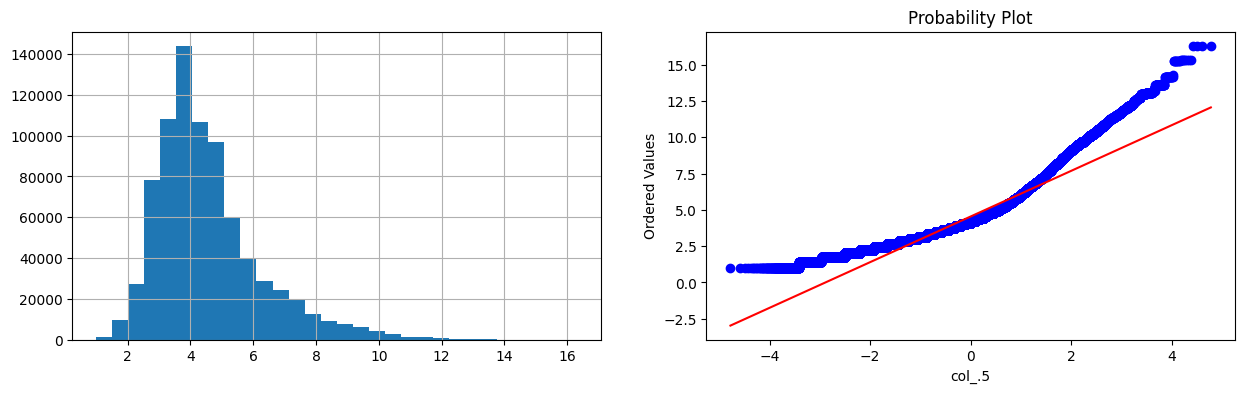

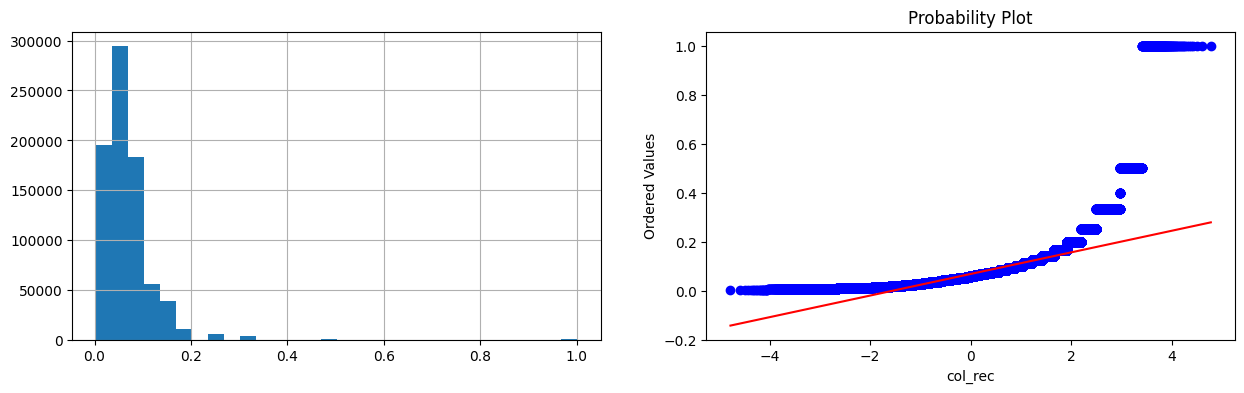

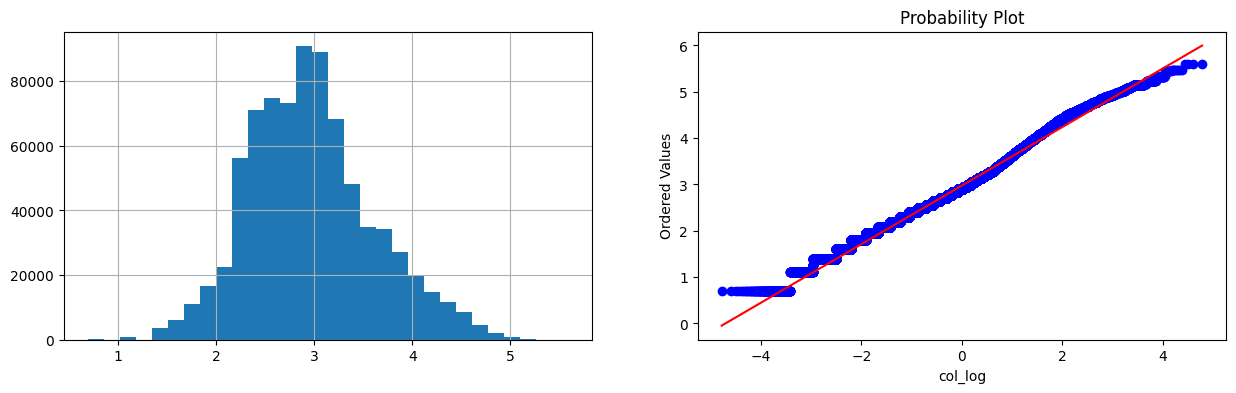

Creatinine
actual plot


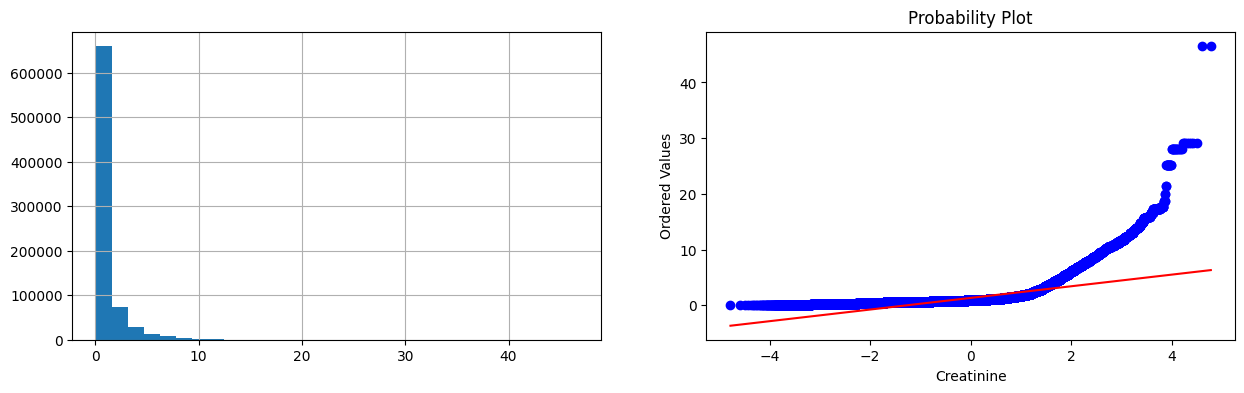

yeojohnson plot


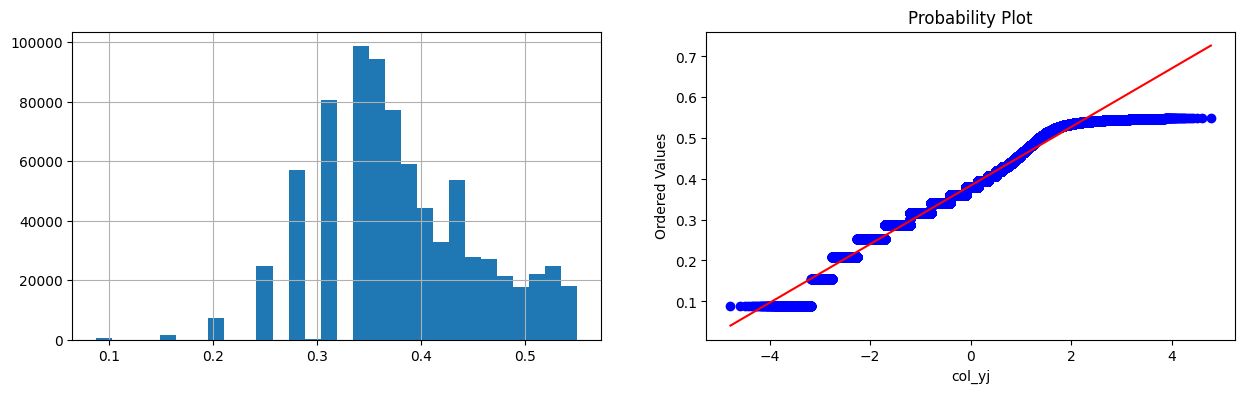

**1/1.5 plot


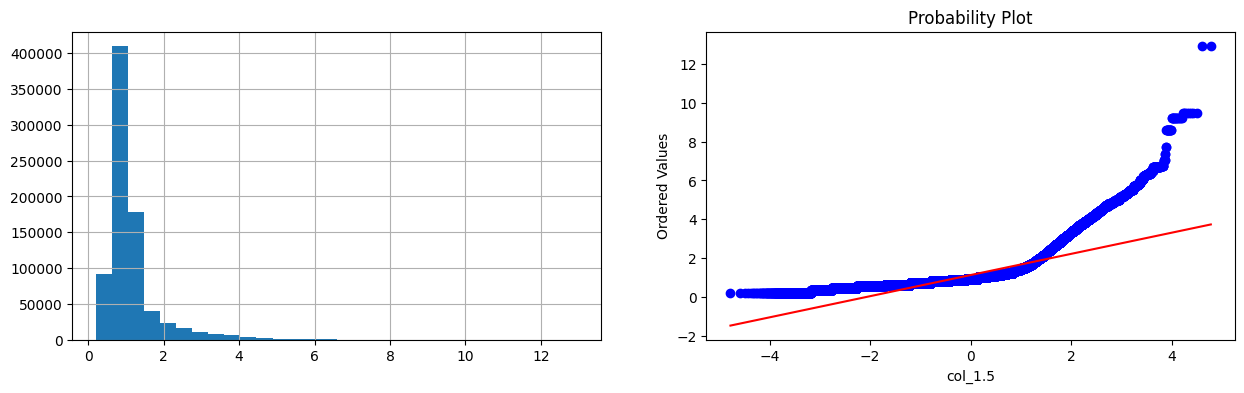

**.5 plot


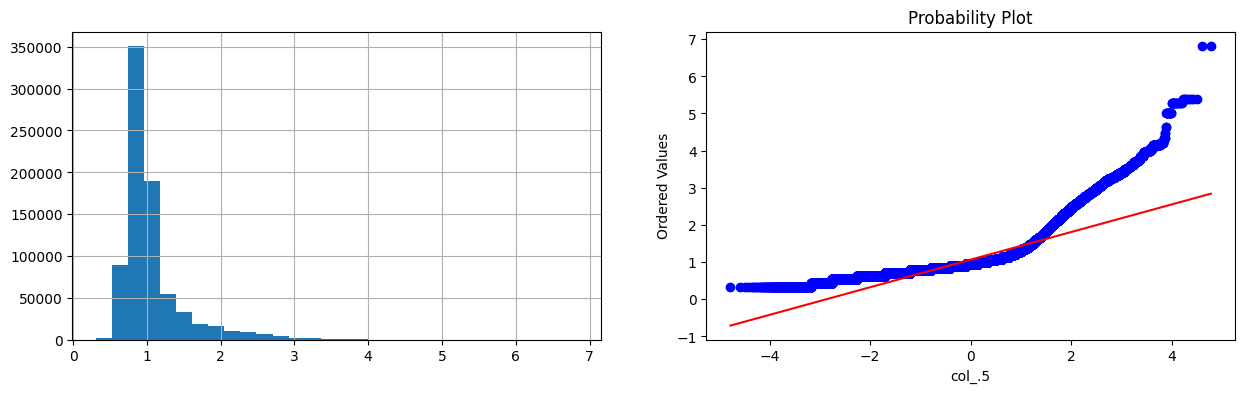

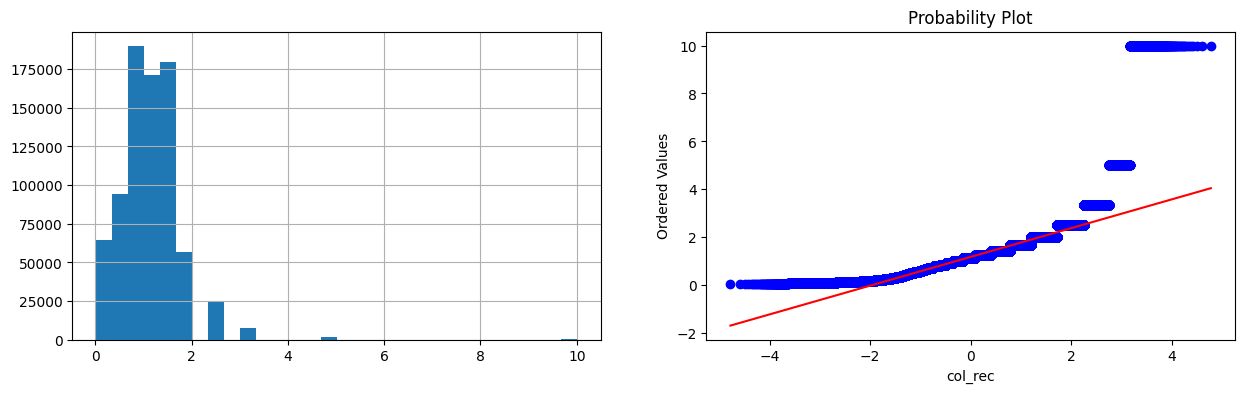

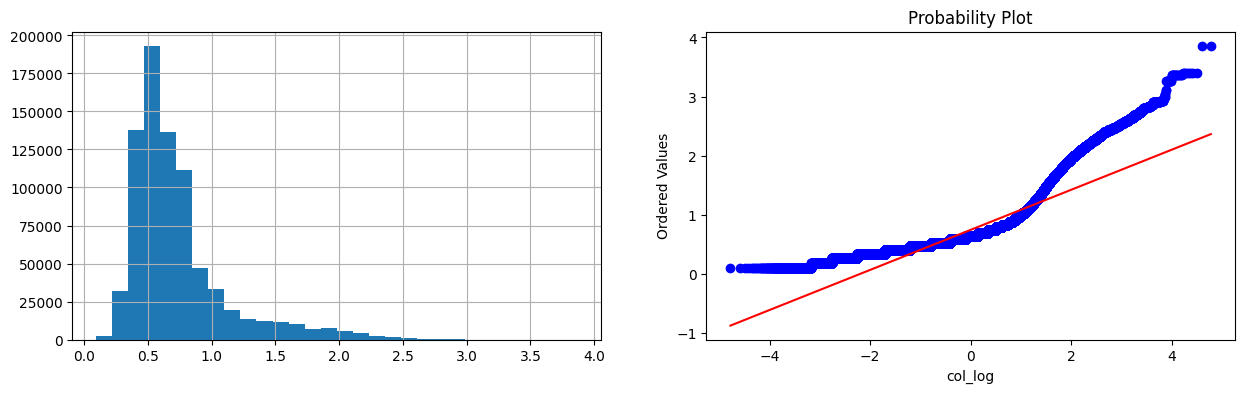

Glucose
actual plot


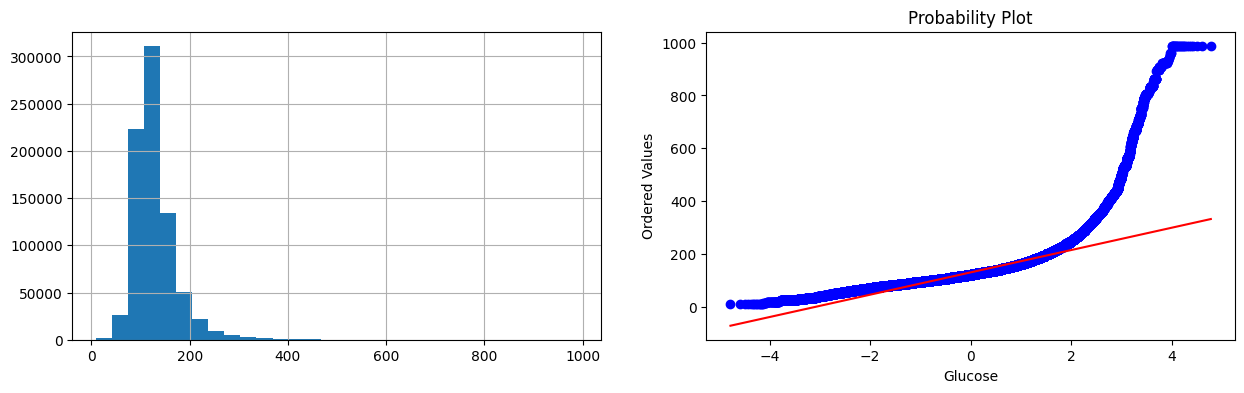

yeojohnson plot


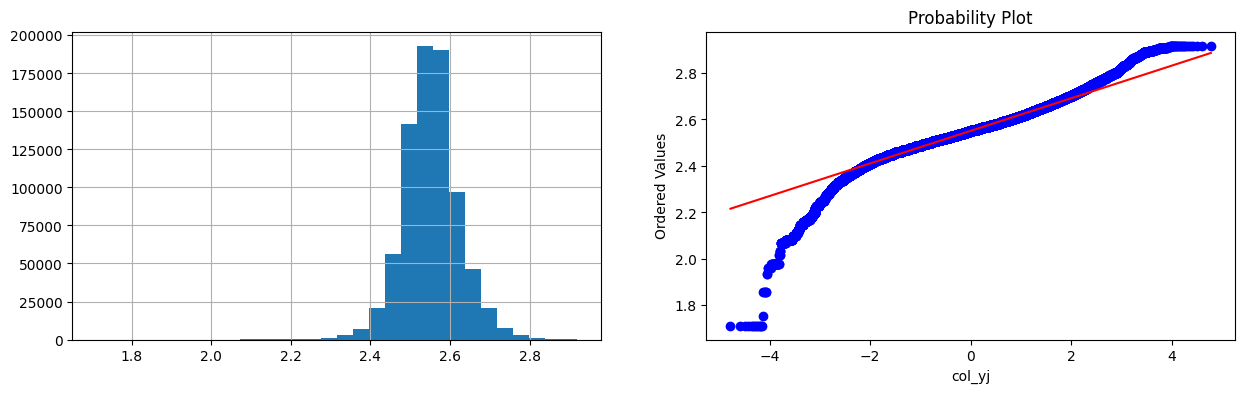

**1/1.5 plot


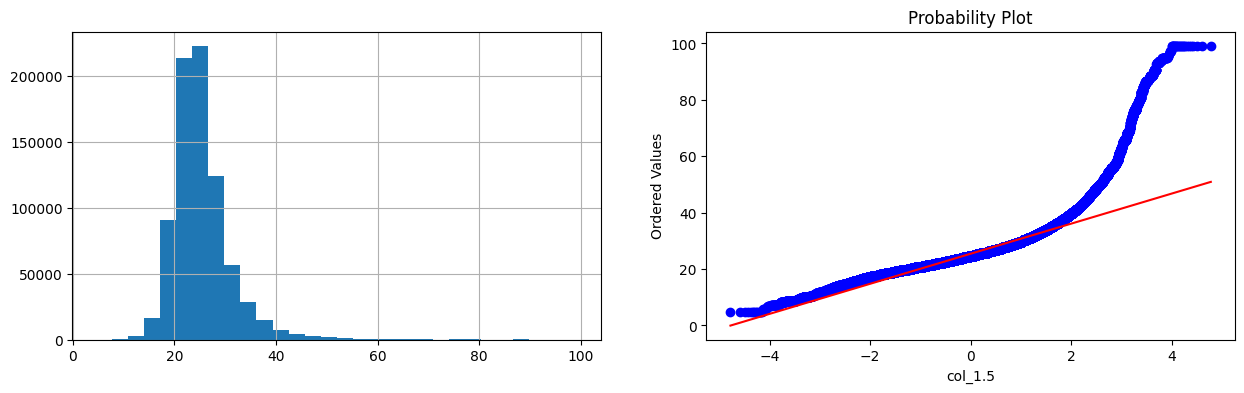

**.5 plot


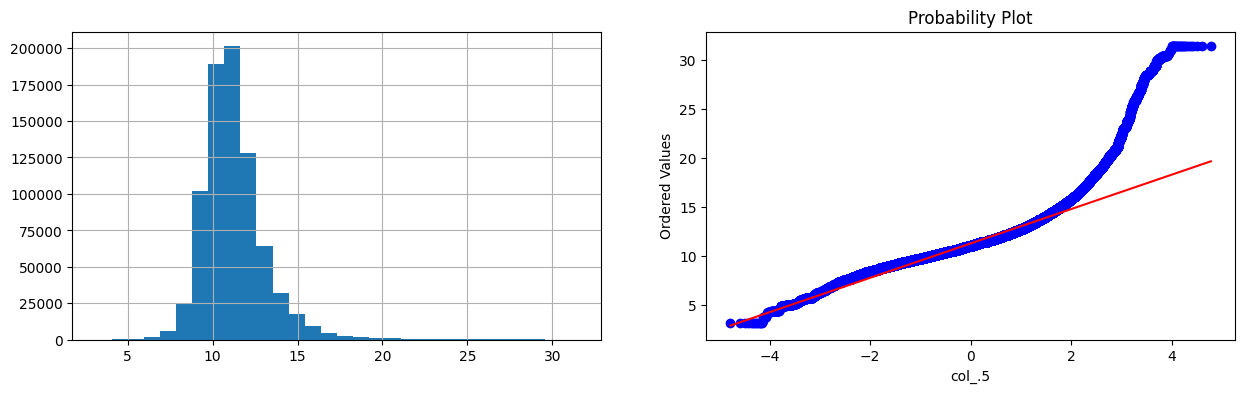

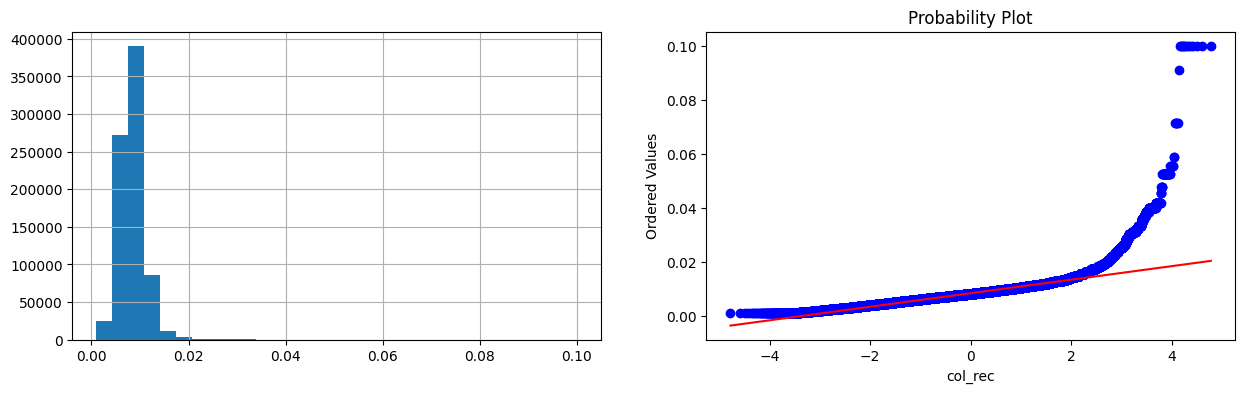

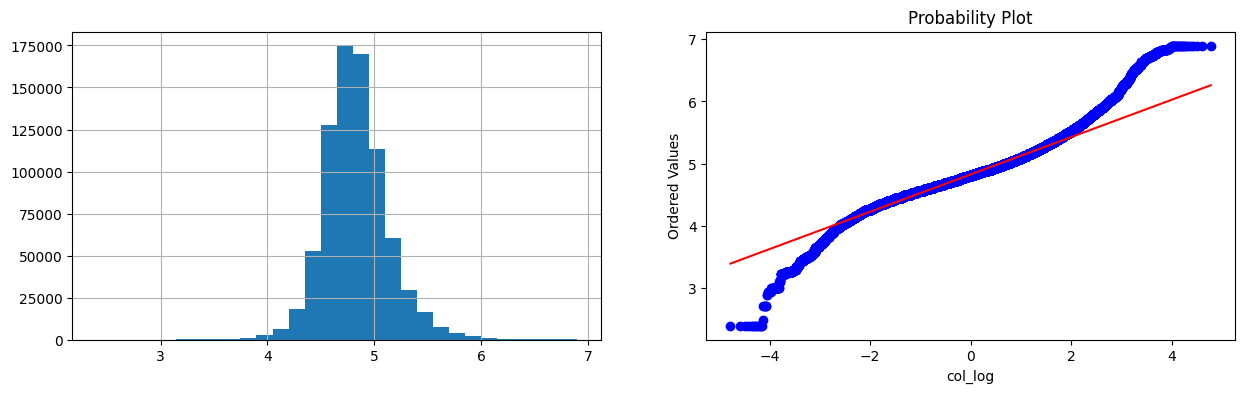

WBC
actual plot


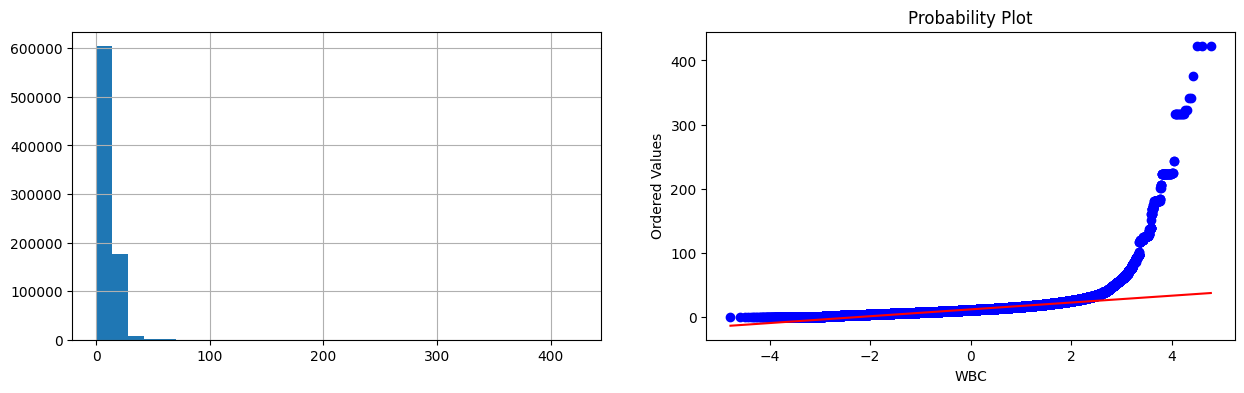

yeojohnson plot


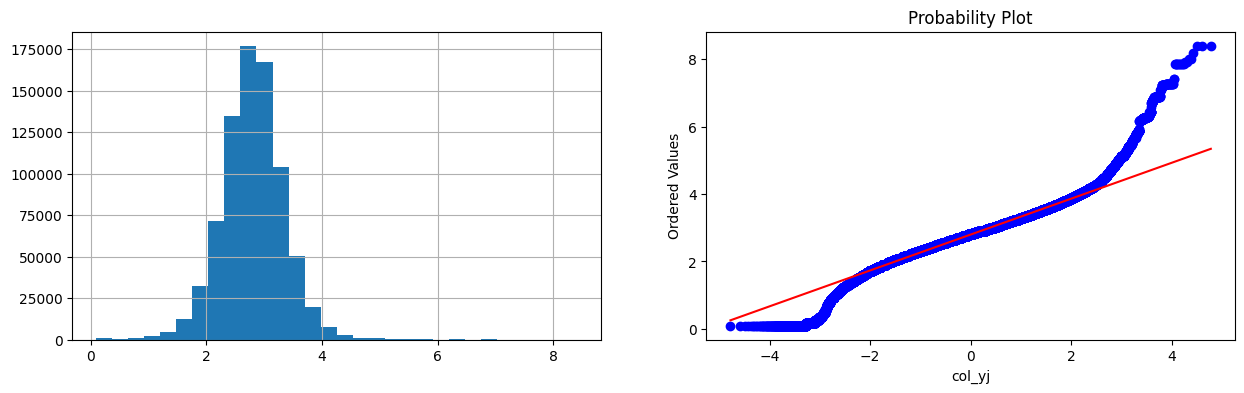

**1/1.5 plot


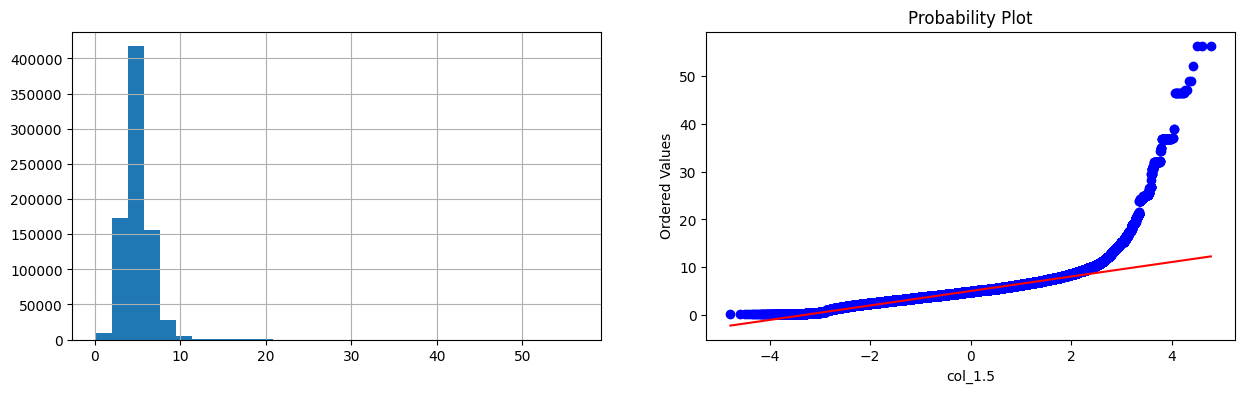

**.5 plot


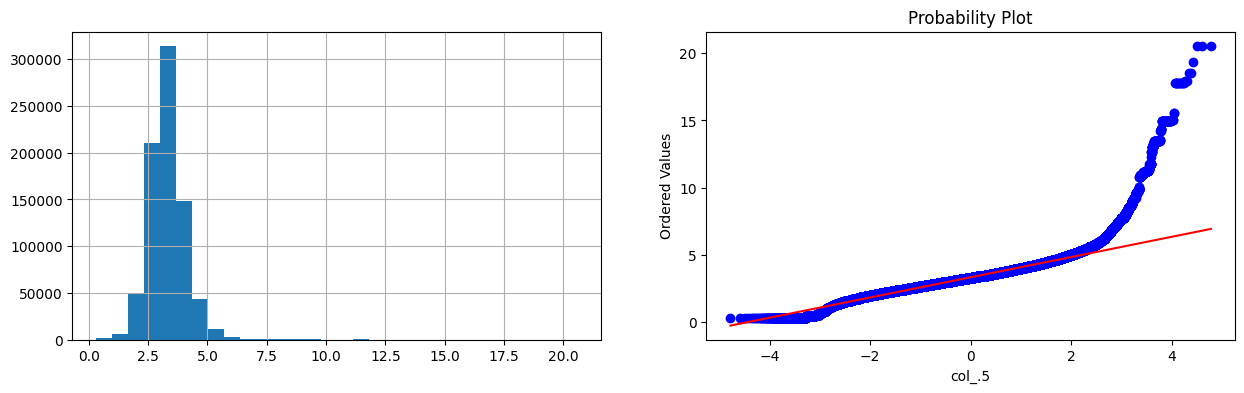

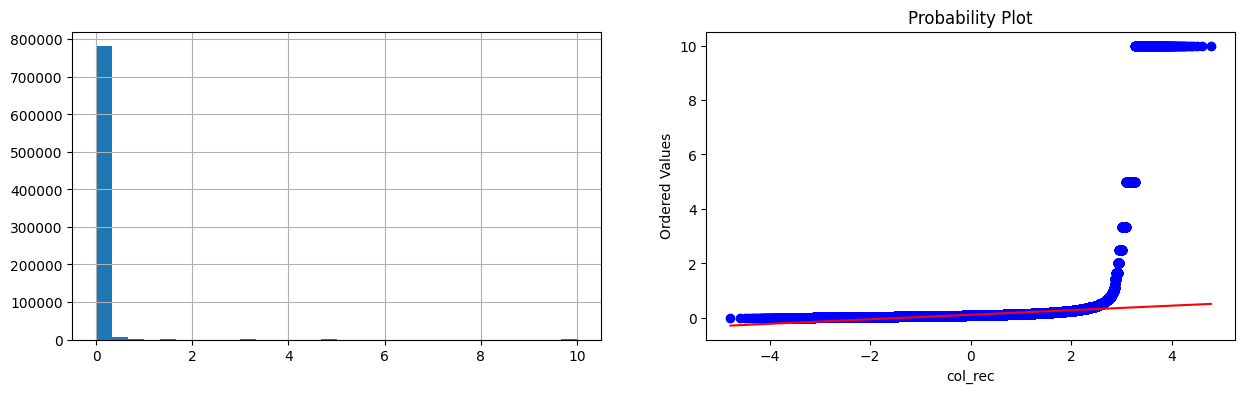

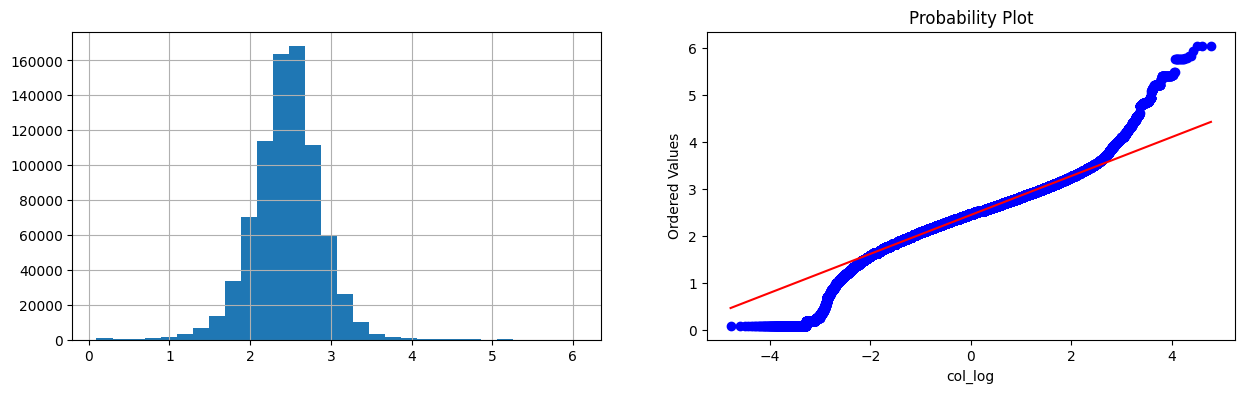

Platelets
actual plot


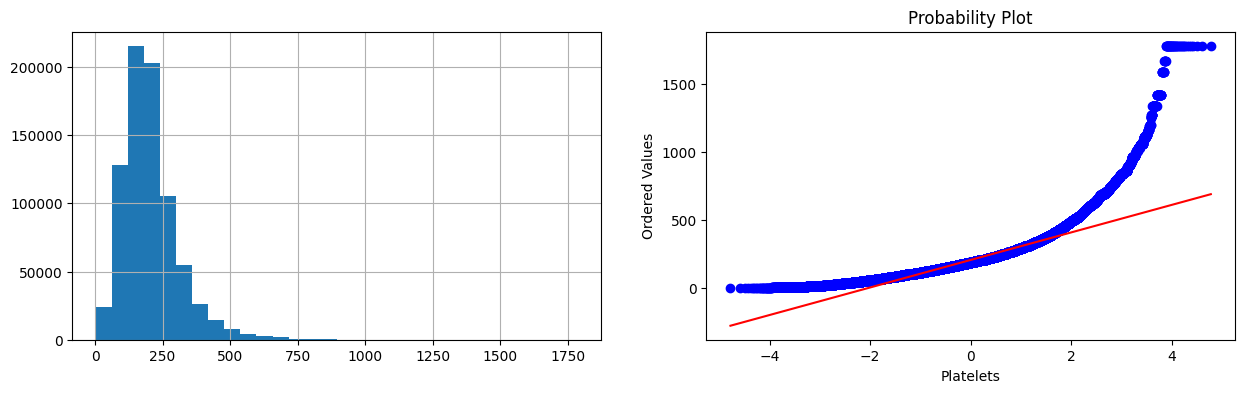

yeojohnson plot


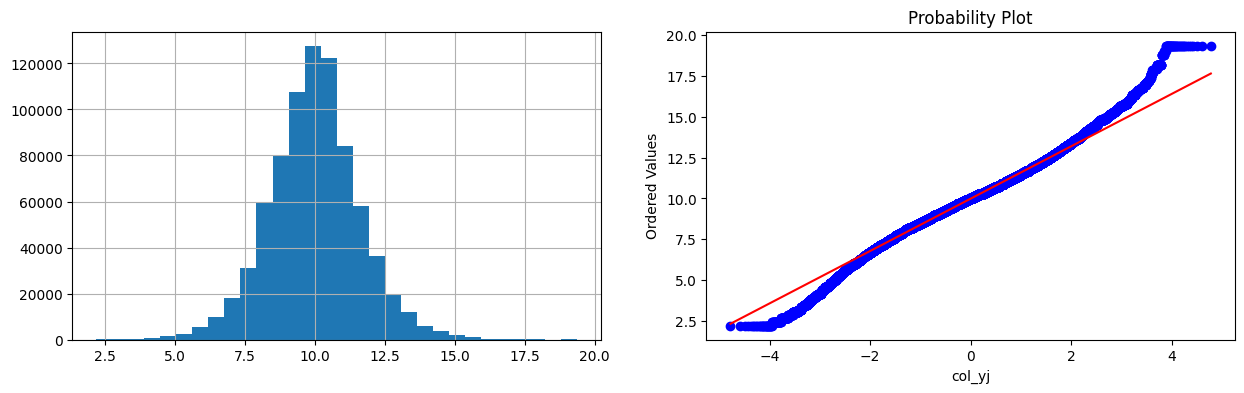

**1/1.5 plot


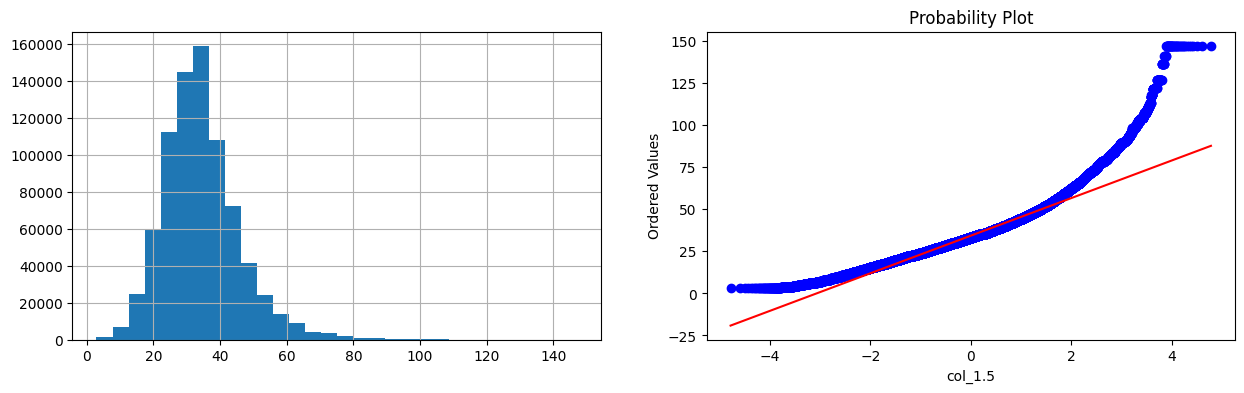

**.5 plot


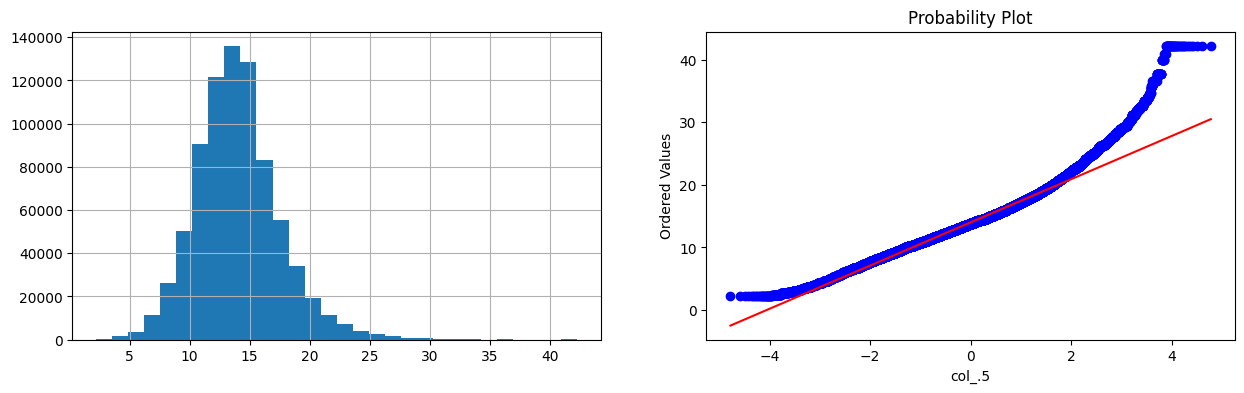

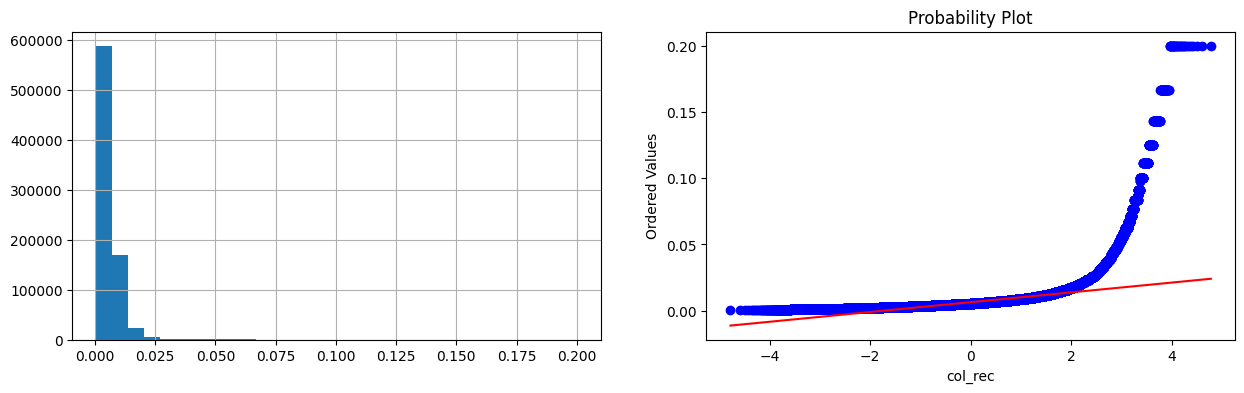

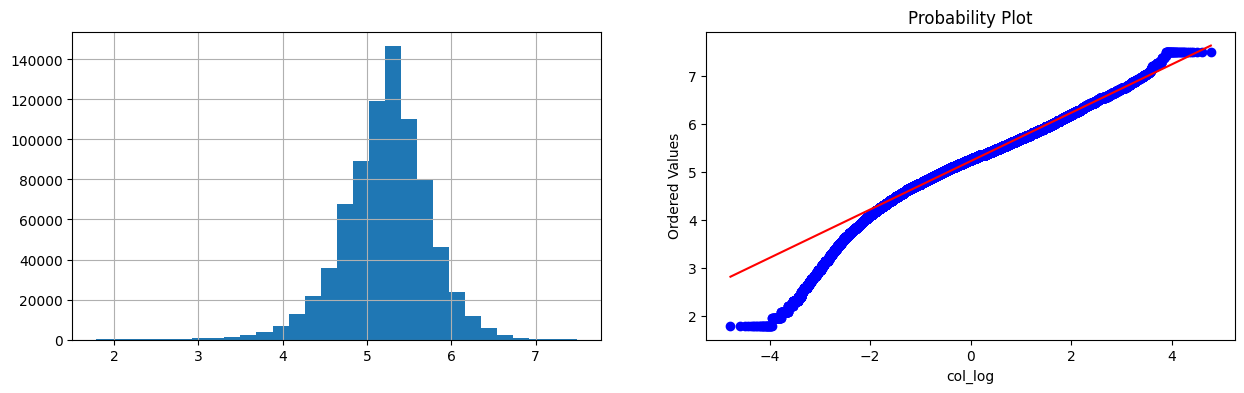

In [23]:
# try normal distribution
# Now we try to check the distribution of values present in different columns after application of various transformations

lst = ['O2Sat', 'Temp', 'MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in lst:
  print(i)
  try_gaussian(df_train_impute, i)

In [24]:
# after application of the above code, some redundant columns got added to the dataframe, which are removed through this line of code
df_train_impute = df_train_impute.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

In [25]:
df_train_impute.head()

Hour     HR  O2Sat   Temp    MAP  Resp   BUN  Chloride  \
Patient_ID                                                                  
1          132940     0   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132941     1   97.0   95.0  36.11  75.33  19.0  14.0      85.0   
           132942     2   89.0   99.0  36.11  86.00  22.0  14.0      85.0   
           132943     3   90.0   95.0  36.11  91.33  30.0  14.0      85.0   
           132944     4  103.0   88.5  36.11  91.33  24.5  14.0      85.0   

                   Creatinine  Glucose   Hct   Hgb  WBC  Platelets    Age  \
Patient_ID                                                                  
1          132940         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132941         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132942         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132943         0.7    193.0  37.2  12.5  5.7      317.0  83.14   
           132944         0.7    193.0  37.2  12.5  5.7      317.0  83.14   

                   HospAdmTime  ICULOS  SepsisLabel     0      1  
Patient_ID                                                        
1          132940        -0.03       1            0  True  False  
           132941        -0.03       2            0  True  False  
           132942        -0.03       3            0  True  False  
           132943        -0.03       4            0  True  False  
           132944        -0.03       5            0  True  False

In [26]:
columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
for i in columns_normalized:
  df_train_impute[i] = np.log(df_train_impute[i]+1)

In [27]:
scaler = StandardScaler()
df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df_train_impute[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132941     1  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132942     2  0.236955  0.555103 -1.110574  0.547993  0.600192   
           132943     3  0.295579 -0.685918 -1.110574  0.868483  2.083649   
           132944     4  1.057696 -2.702577 -1.110574  0.868483  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132941 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132942 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132943 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132944 -0.418013 -3.697098   -0.565677  1.449281  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.301586   1.066178  83.14        -0.03       1   
           132941  1.114903 -1.301586   1.066178  83.14        -0.03       2   
           132942  1.114903 -1.301586   1.066178  83.14        -0.03       3   
           132943  1.114903 -1.301586   1.066178  83.14        -0.03       4   
           132944  1.114903 -1.301586   1.066178  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [28]:
df_train_impute = df_train_impute.dropna()

In [29]:
null_values = df_train_impute.isnull().mean()*100
null_values

,0
Hour,0.0
HR,0.0
O2Sat,0.0
Temp,0.0
MAP,0.0
Resp,0.0
BUN,0.0
Chloride,0.0
Creatinine,0.0
Glucose,0.0


In [30]:
df_train_impute.head()

Hour        HR     O2Sat      Temp       MAP      Resp  \
Patient_ID                                                                  
1          132940     0  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132941     1  0.705950 -0.685918 -1.110574 -0.157233  0.043895   
           132942     2  0.236955  0.555103 -1.110574  0.547993  0.600192   
           132943     3  0.295579 -0.685918 -1.110574  0.868483  2.083649   
           132944     4  1.057696 -2.702577 -1.110574  0.868483  1.063772   

                        BUN  Chloride  Creatinine   Glucose       Hct  \
Patient_ID                                                              
1          132940 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132941 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132942 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132943 -0.418013 -3.697098   -0.565677  1.449281  1.231844   
           132944 -0.418013 -3.697098   -0.565677  1.449281  1.231844   

                        Hgb       WBC  Platelets    Age  HospAdmTime  ICULOS  \
Patient_ID                                                                     
1          132940  1.114903 -1.301586   1.066178  83.14        -0.03       1   
           132941  1.114903 -1.301586   1.066178  83.14        -0.03       2   
           132942  1.114903 -1.301586   1.066178  83.14        -0.03       3   
           132943  1.114903 -1.301586   1.066178  83.14        -0.03       4   
           132944  1.114903 -1.301586   1.066178  83.14        -0.03       5   

                   SepsisLabel     0      1  
Patient_ID                                   
1          132940            0  True  False  
           132941            0  True  False  
           132942            0  True  False  
           132943            0  True  False  
           132944            0  True  False

In [31]:
def get_data_ready(df):
  columns_drop={'Unnamed: 0','SBP','DBP','EtCO2','BaseExcess', 'HCO3','pH','PaCO2','Alkalinephos', 'Calcium','Magnesium',
  'Phosphate','Potassium','PTT','Fibrinogen','Unit1','Unit2'}
  df = df.assign(Unit=df['Unit1'] + df['Unit2'])
  # dropping columns based on redundancy
  df = df.drop(columns=columns_drop)
  grouped_by_patient = df.groupby('Patient_ID')
  # imputing backfill and forward fill
  df = grouped_by_patient.apply(lambda x: x.bfill().ffill())
  # dropping all the columns with null values more than 25% and patient_id
  null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2','Unit', 'Patient_ID']
  df = df.drop(columns=null_col)
  # gaussian transformation
  columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
  for i in columns_normalized:
    df[i] = np.log(df[i]+1)
  # normailizing
  scaler = StandardScaler()
  df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']] = scaler.fit_transform(df[['HR', 'O2Sat', 'Temp', 'MAP', 'Resp', 'BUN', 'Chloride',
       'Creatinine', 'Glucose', 'Hct', 'Hgb', 'WBC', 'Platelets']])
  # onehot encoding the gender
  one_hot = pd.get_dummies(df['Gender'])
  df = df.join(one_hot)
  df = df.drop('Gender', axis=1)
  df = df.dropna()
  return df

In [32]:
majority_class = df_train_impute[df_train_impute['SepsisLabel'] == 0]
minority_class = df_train_impute[df_train_impute['SepsisLabel'] == 1]
print('number of sepsis label 1 is {}'.format(len(minority_class)))
print('while number of sepsis label 0 is {}'.format(len(majority_class)))

number of sepsis label 1 is 15694
while number of sepsis label 0 is 760125


In [33]:
majority_class_subset = majority_class.sample(n=2*len(minority_class))
df_train_impute = pd.concat([majority_class_subset, minority_class])

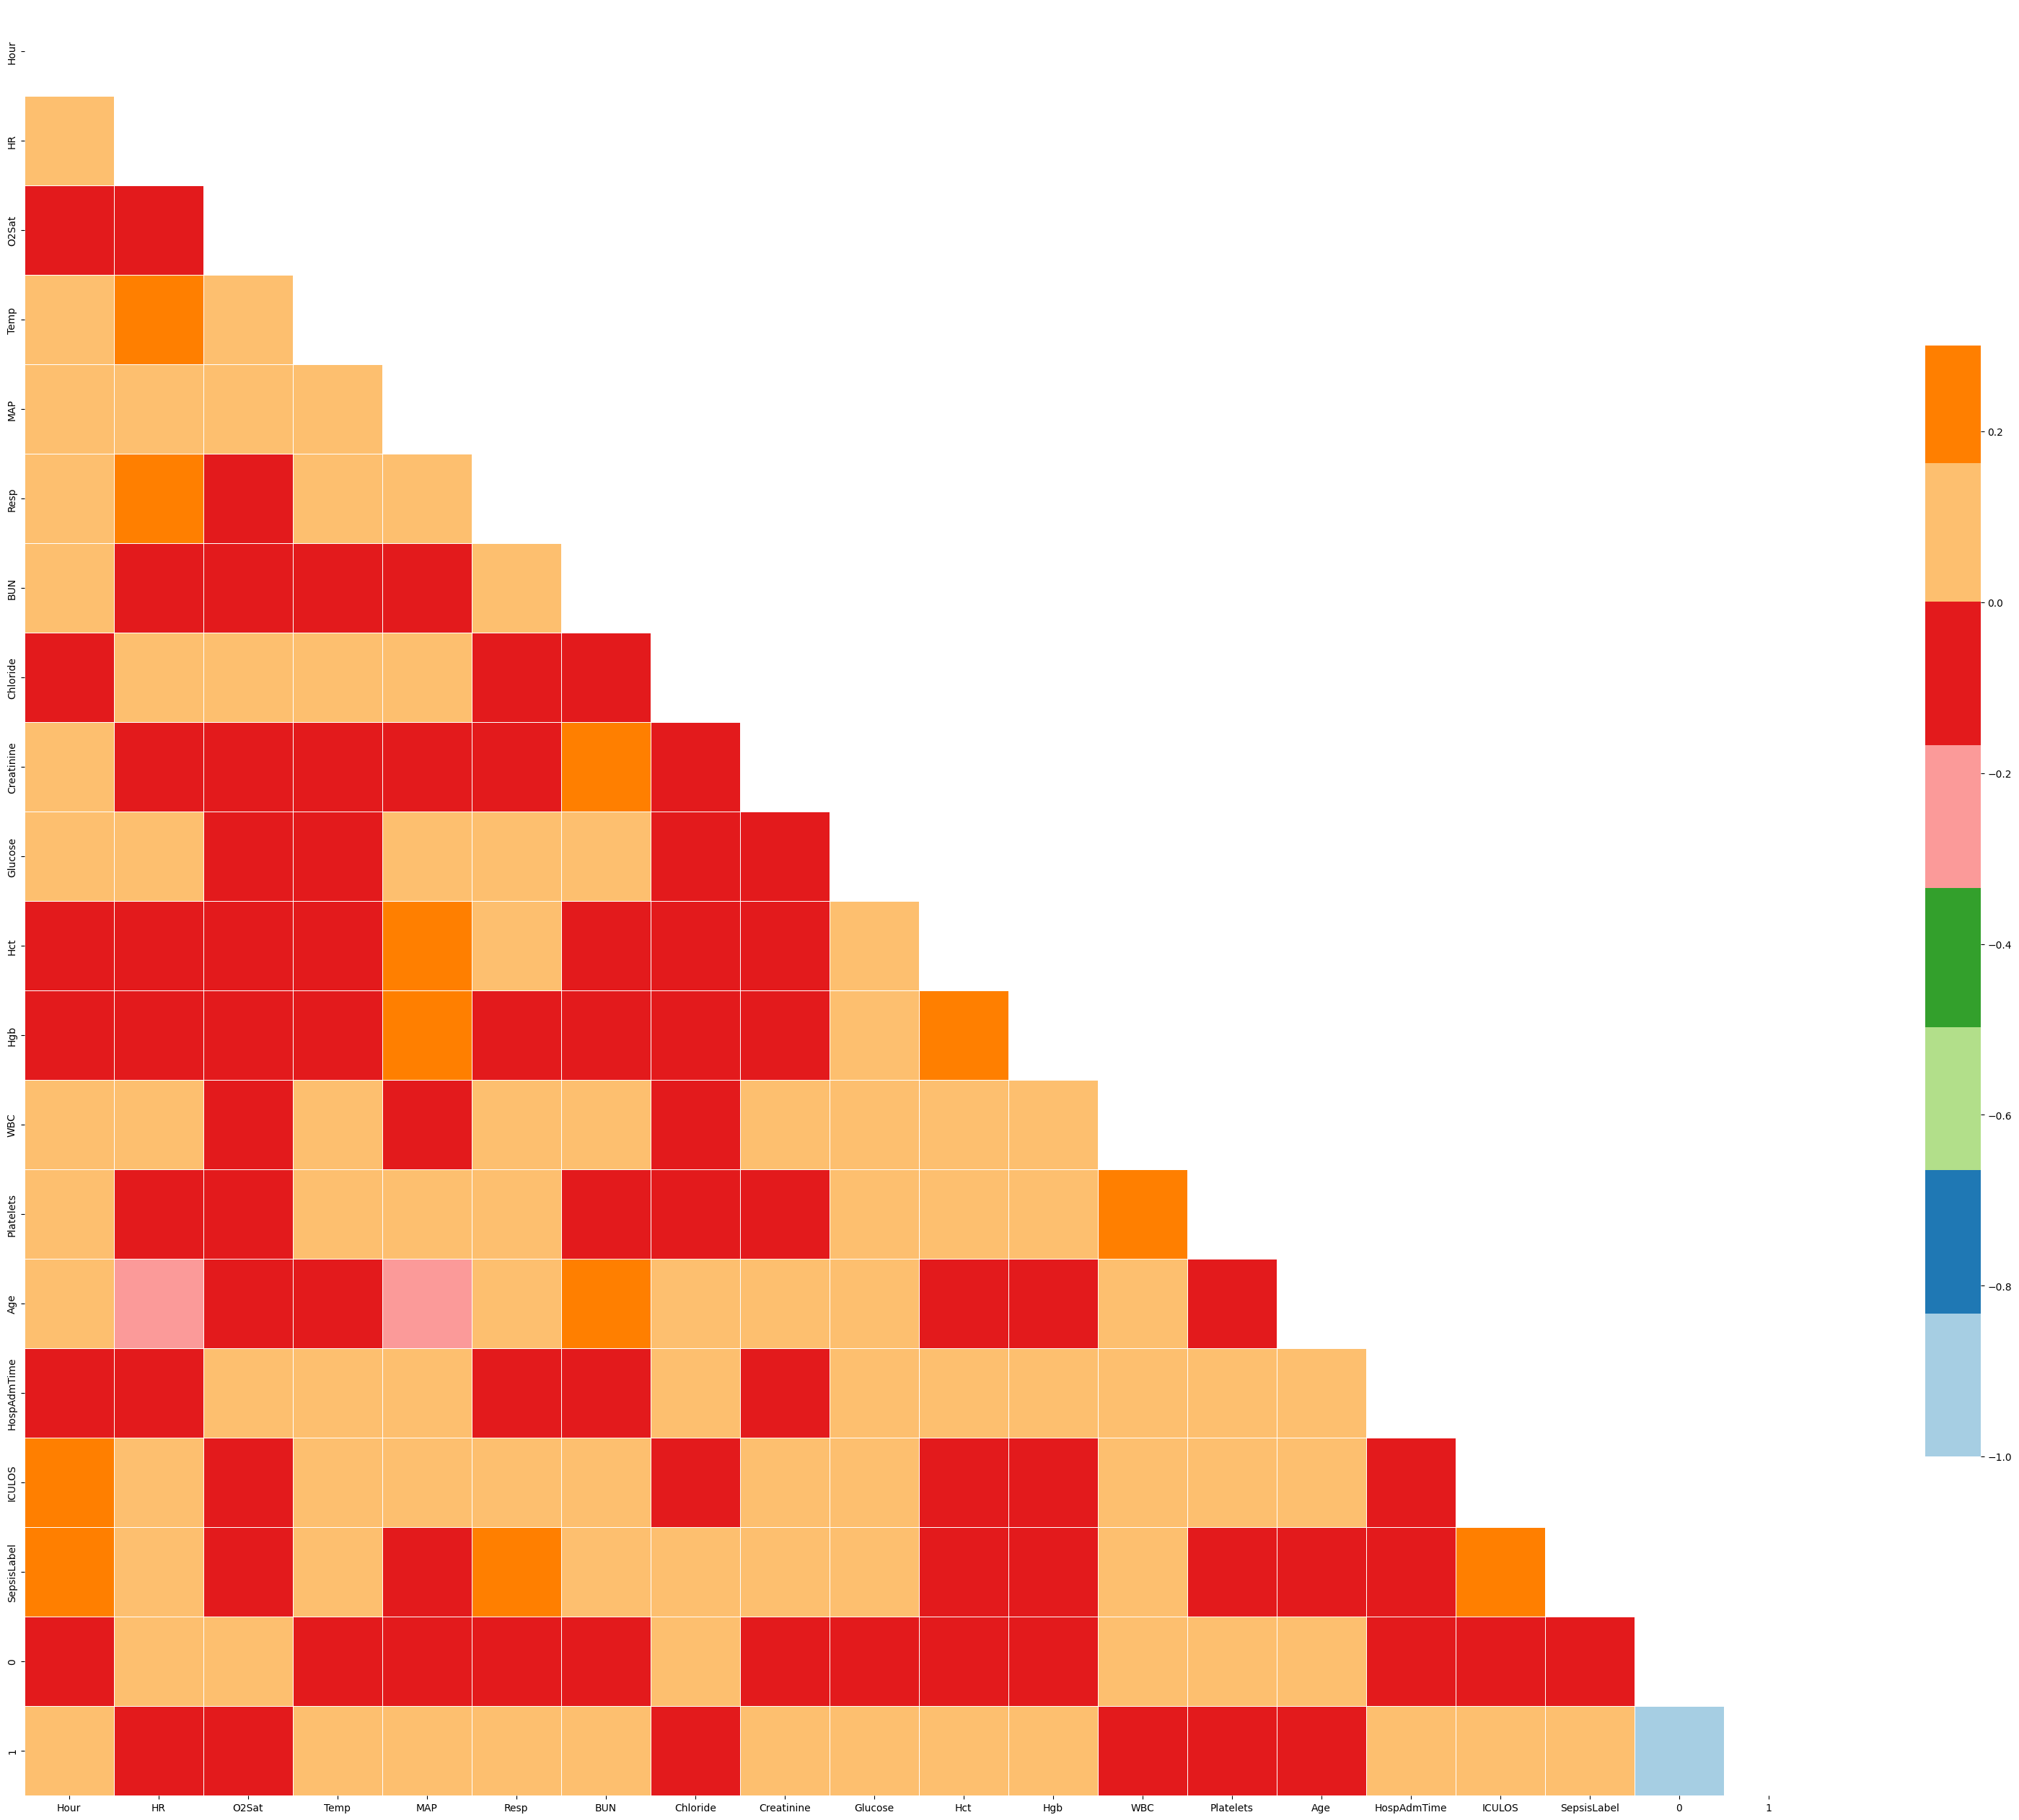

In [34]:
corr_matrix(df_train_impute)

In [35]:
X = df_train_impute.drop('SepsisLabel', axis=1)
X.columns = X.columns.astype(str)
y = df_train_impute['SepsisLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)
rcf_predictions = model.predict(X_test)

In [37]:
def evaluate_model(y_true,y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  print("Accuracy:", accuracy)
  precision = precision_score(y_true, y_pred)
  print("Precision:", precision)
  recall = recall_score(y_true, y_pred)
  print("Recall:", recall)
  f1 = f1_score(y_true, y_pred)
  print("F1 Score:", f1)
  auc = roc_auc_score(y_true, y_pred)
  print("AUC-ROC:", auc)
  mae = mean_absolute_error(y_true, y_pred)
  print("Mean Absolute Error:", mae)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  print("Root Mean Squared Error:", rmse)
  cm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cm, annot=True, fmt='d')
  cm = confusion_matrix(y_true, y_pred)
  tn, fp, fn, tp = cm.ravel()
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
  print("Specificity: ", specificity)
  plt.show()
  RocCurveDisplay.from_estimator(model, X_test, y_true)
  plt.title("ROC Curve")
  plt.show()

Accuracy: 0.9600722098332802
Precision: 0.9207675642216032
Recall: 0.9612277867528272
F1 Score: 0.9405627568763831
AUC-ROC: 0.9603671360211463
Mean Absolute Error: 0.03992779016671976
Root Mean Squared Error: 0.19981939387036424
Specificity:  0.9595064852894654


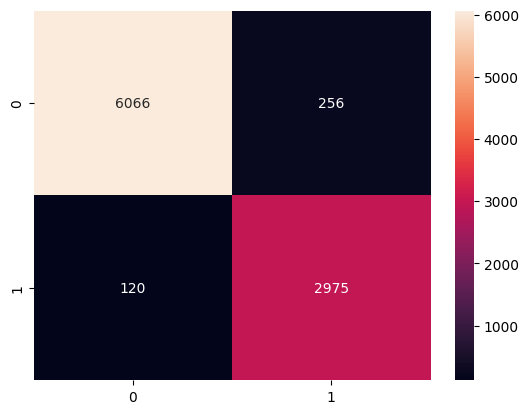

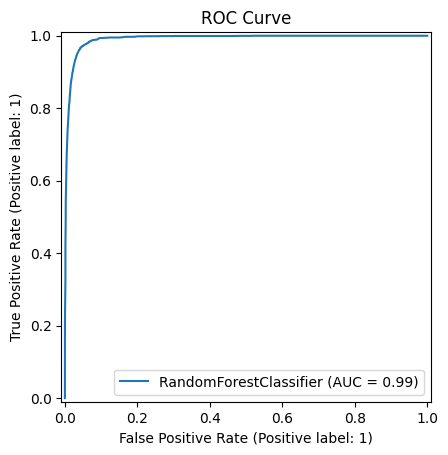

In [43]:
evaluate_model(y_test,rcf_predictions)